# Capstone Project: Moving the Bottom Line Needle: Classifying Performance of Sales Representatives in a Technology Company

### Student: Tan Wei Jie
### Academic Supervisor: Mr Herman Tan
### Company Supervisor: Mr Leonard Goh

## Load libraries and datasets

In [6]:
import os
import pandas as pd
import numpy as np
import random as rd
import datetime as dt
import re
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import time
import csv
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import metrics
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.compose import  ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB, ComplementNB, CategoricalNB
from sklearn.svm import SVC  
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
from itertools import cycle

import joblib

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

In [87]:
#change directory to required folder
os.chdir('C:/')

In [88]:
#load in the FY21 sales attainment data
df = pd.read_csv('./data/FY21 Classifying Performance of Sales Reps - Sample Dataset v2.csv')

In [89]:
df.head()

,Unnamed: 0,SUBREGION,COUNTRY,CAREER_LEVEL,TENURE_CONTINUOUS_SERVICE_DATE_BAND,TENURE_LATEST_HIRE_DATE_BAND,JOB_TENURE_BAND,TENURE_CONTINUOUS_SERVICE_DATE_IN_YEARS,TENURE_LATEST_SERVICE_DATE_IN_YEARS,JOB_TENURE_IN_YEARS,TIME_SINCE_LAST_SALARY_INCR_BAND,GENDER,AGE_BAND,PRODUCT_LINE,PRODUCT_ASSOCIATION,RCODE_06,RCODE_07,ATTAINMENT_REP_LEVEL_FY21,ATTAINMENT_REP_LEVEL_FY20,MANAGER180_OVERALL,# of Salary Change FY20,# of Salary Change FY21,# of Org Change FY20,# of Org Change FY21,# of Career Level Change FY20,# of Career Level Change FY21,# of Manager Change FY20,# of Manager Change FY21,# of Job Change FY20,# of Job Change FY21,# of Location Change FY20,# of Location Change FY21,Nationality,Manager_Gender Desc,Hire Event Description,MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL
0,4680,India,India,IC4,2 to < 5 Yrs,2 to < 5 Yrs,2 to < 5 Yrs,2.583333,2.583333,2.583333,2 to < 5 Yrs,M,40-49 Years,Apps,HCM,APAC Software Sales,APAC APPS LICENSE,12.25,56.00,100.0,0,0,2,0,0,0,0,0,0,0,0,0,IN,Male,HIRE EVENT,Internally Promoted Manager
1,4287,Korea,South Korea,IC3,5 to < 10 Yrs,5 to < 10 Yrs,5 to < 10 Yrs,9.000000,9.000000,7.583333,<1 Yr,M,40-49 Years,Tech,Tech Cloud,APAC Software Sales,APAC TECH LICENSE,42.70,94.27,0.0,0,1,2,1,0,0,3,0,0,0,0,0,KR,Male,HIRE EVENT,Externally Hired Manager
2,4388,Japan,Japan,IC4,1 to < 2 Yrs,1 to < 2 Yrs,1 to < 2 Yrs,1.333333,1.333333,1.333333,1 to < 2 Yrs,M,40-49 Years,Tech,Tech License,Japan Software Sales,JP - CTBU,91.44,125.21,100.0,0,0,0,1,0,0,0,1,0,0,0,0,JP,Male,HIRE EVENT,Internally Promoted Manager
3,522,China,China,IC3,2 to < 5 Yrs,2 to < 5 Yrs,2 to < 5 Yrs,4.500000,4.500000,4.500000,2 to < 5 Yrs,M,30-39 Years,Apps,ERP,APAC Software Sales,APAC APPS LICENSE,33.44,80.45,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,Male,HIRE EVENT,Internally Promoted Manager
4,573,India,India,IC2,1 to < 2 Yrs,1 to < 2 Yrs,<1 Yr,1.250000,1.250000,0.416667,<1 Yr,M,30-39 Years,Tech,Tech Cloud,APAC Software Sales,APAC TECH LICENSE,66.19,22.22,NaN,0,0,2,1,0,0,1,1,0,1,1,0,IN,Male,TRANSFER EVENT,Internally Promoted Manager


In [90]:
df.shape

(872, 36)

## Modelling Step 1. Data Preprocessing

In [91]:
#rename columns

df = df.rename({'# of Salary Change FY20': 'NUM_SALARY_CHANGE_PREV_FY',
               '# of Salary Change FY21': 'NUM_SALARY_CHANGE_CURR_FY',
               '# of Org Change FY20': 'NUM_ORG_CHANGE_PREV_FY', 
                '# of Org Change FY21':'NUM_ORG_CHANGE_CURR_FY',
                '# of Career Level Change FY20':'NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                '# of Career Level Change FY21':'NUM_CAREER_LEVEL_CHANGE_CURR_FY',
               '# of Manager Change FY20': 'NUM_MANAGER_CHANGE_PREV_FY',
               '# of Manager Change FY21': 'NUM_MANAGER_CHANGE_CURR_FY',
               '# of Job Change FY20':'NUM_JOB_CHANGE_PREV_FY',
                '# of Job Change FY21':'NUM_JOB_CHANGE_CURR_FY',
                '# of Location Change FY20':'NUM_LOCATION_CHANGE_PREV_FY',
                '# of Location Change FY21':'NUM_LOCATION_CHANGE_CURR_FY',
                'ATTAINMENT_REP_LEVEL_FY20':'ATTAINMENT_REP_LEVEL_PREV_FY',
               'MANAGER180_OVERALL':'MANAGER180_OVERALL_CURR_FY'}, axis=1)



In [92]:
#for all column headers, remove white spaces, remove punctuation and convert to uppercase
df.columns = df.columns.str.replace('\s', '_', regex=True).str.replace('[^\w\s]', '', regex=True).str.upper()


In [93]:
df.head(2)

,UNNAMED_0,SUBREGION,COUNTRY,CAREER_LEVEL,TENURE_CONTINUOUS_SERVICE_DATE_BAND,TENURE_LATEST_HIRE_DATE_BAND,JOB_TENURE_BAND,TENURE_CONTINUOUS_SERVICE_DATE_IN_YEARS,TENURE_LATEST_SERVICE_DATE_IN_YEARS,JOB_TENURE_IN_YEARS,TIME_SINCE_LAST_SALARY_INCR_BAND,GENDER,AGE_BAND,PRODUCT_LINE,PRODUCT_ASSOCIATION,RCODE_06,RCODE_07,ATTAINMENT_REP_LEVEL_FY21,ATTAINMENT_REP_LEVEL_PREV_FY,MANAGER180_OVERALL_CURR_FY,NUM_SALARY_CHANGE_PREV_FY,NUM_SALARY_CHANGE_CURR_FY,NUM_ORG_CHANGE_PREV_FY,NUM_ORG_CHANGE_CURR_FY,NUM_CAREER_LEVEL_CHANGE_PREV_FY,NUM_CAREER_LEVEL_CHANGE_CURR_FY,NUM_MANAGER_CHANGE_PREV_FY,NUM_MANAGER_CHANGE_CURR_FY,NUM_JOB_CHANGE_PREV_FY,NUM_JOB_CHANGE_CURR_FY,NUM_LOCATION_CHANGE_PREV_FY,NUM_LOCATION_CHANGE_CURR_FY,NATIONALITY,MANAGER_GENDER_DESC,HIRE_EVENT_DESCRIPTION,MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL
0,4680,India,India,IC4,2 to < 5 Yrs,2 to < 5 Yrs,2 to < 5 Yrs,2.583333,2.583333,2.583333,2 to < 5 Yrs,M,40-49 Years,Apps,HCM,APAC Software Sales,APAC APPS LICENSE,12.25,56.00,100.0,0,0,2,0,0,0,0,0,0,0,0,0,IN,Male,HIRE EVENT,Internally Promoted Manager
1,4287,Korea,South Korea,IC3,5 to < 10 Yrs,5 to < 10 Yrs,5 to < 10 Yrs,9.000000,9.000000,7.583333,<1 Yr,M,40-49 Years,Tech,Tech Cloud,APAC Software Sales,APAC TECH LICENSE,42.70,94.27,0.0,0,1,2,1,0,0,3,0,0,0,0,0,KR,Male,HIRE EVENT,Externally Hired Manager


In [94]:
#check for any duplicates
#df_check = df[['EMAIL_ADDRESS']]

# df_dup = df_check[df_check.duplicated(subset=['EMAIL_ADDRESS'], keep=False)]
# df_dup

In [95]:
df1 = df.copy()

In [96]:
#round attainment values to 2 decimal places
df1['ATTAINMENT_REP_LEVEL_FY21'] = round(df1['ATTAINMENT_REP_LEVEL_FY21'],2)
df1['ATTAINMENT_REP_LEVEL_PREV_FY'] = round(df1['ATTAINMENT_REP_LEVEL_PREV_FY'],2)



In [97]:
#check for null values in attainment
print(df1['ATTAINMENT_REP_LEVEL_FY21'].isnull().sum())
print(df1['ATTAINMENT_REP_LEVEL_PREV_FY'].isnull().sum())


0
65


In [98]:
#check if there are any attainment values that are negative
df1.loc[df1['ATTAINMENT_REP_LEVEL_PREV_FY'] < 0.00]

,UNNAMED_0,SUBREGION,COUNTRY,CAREER_LEVEL,TENURE_CONTINUOUS_SERVICE_DATE_BAND,TENURE_LATEST_HIRE_DATE_BAND,JOB_TENURE_BAND,TENURE_CONTINUOUS_SERVICE_DATE_IN_YEARS,TENURE_LATEST_SERVICE_DATE_IN_YEARS,JOB_TENURE_IN_YEARS,TIME_SINCE_LAST_SALARY_INCR_BAND,GENDER,AGE_BAND,PRODUCT_LINE,PRODUCT_ASSOCIATION,RCODE_06,RCODE_07,ATTAINMENT_REP_LEVEL_FY21,ATTAINMENT_REP_LEVEL_PREV_FY,MANAGER180_OVERALL_CURR_FY,NUM_SALARY_CHANGE_PREV_FY,NUM_SALARY_CHANGE_CURR_FY,NUM_ORG_CHANGE_PREV_FY,NUM_ORG_CHANGE_CURR_FY,NUM_CAREER_LEVEL_CHANGE_PREV_FY,NUM_CAREER_LEVEL_CHANGE_CURR_FY,NUM_MANAGER_CHANGE_PREV_FY,NUM_MANAGER_CHANGE_CURR_FY,NUM_JOB_CHANGE_PREV_FY,NUM_JOB_CHANGE_CURR_FY,NUM_LOCATION_CHANGE_PREV_FY,NUM_LOCATION_CHANGE_CURR_FY,NATIONALITY,MANAGER_GENDER_DESC,HIRE_EVENT_DESCRIPTION,MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL


## Modelling Step 2. Exploratory Data Analysis

<font size="3">**Note: EDA charts are based on fictitious data and do not reflect original values**</font>


In [42]:
#plot a histogram to show the distribution of the attainment percentage
plt.figure(figsize = (12,9))

sns.distplot(df1['ATTAINMENT_REP_LEVEL_FY21'], kde=False, color='blue', bins=10)

plt.title('Distribution of Attainment Rep Level for FY21', fontsize=18)
plt.xlabel('Attainment in %)', fontsize=16)
plt.ylabel('Counts', fontsize=16)



In [43]:
#check value counts
df1['ATTAINMENT_REP_LEVEL_FY21'].value_counts()

In [99]:
#bin the attainment values into multiclass categories
#bins were created based on business definition of good and poor performance

bins = [-1, 25, 75, 100, float("inf")]

bands = ['Poor','Average','Good','Great']

df1['ATTAINMENT_REP_LEVEL_BAND_MULTICLASS_FY21'] = pd.cut(df1['ATTAINMENT_REP_LEVEL_FY21'], bins, labels=bands)

In [49]:
#check value counts
df1['ATTAINMENT_REP_LEVEL_BAND_MULTICLASS_FY21'].value_counts()

<font size="3">**Note: Values below 75 are 'Not Good' while values above 75 are 'Good'**</font>


In [100]:
#bin the attainment values into binary categories
#bins were created based on business definition of good and poor performance

bins = [-1, 75, float("inf")]

bands = ['Not Good', 'Good']

df1['ATTAINMENT_REP_LEVEL_BAND_FY21'] = pd.cut(df1['ATTAINMENT_REP_LEVEL_FY21'], bins, labels=bands)

In [101]:
#bin the attainment values into binary categories
#bins were created based on business definition of good and poor performance

bins = [-1, 75, float("inf")]

bands = [0, 1]

df1['ATTAINMENT_REP_LEVEL_BANDNUM_FY21'] = pd.cut(df1['ATTAINMENT_REP_LEVEL_FY21'], bins, labels=bands)

In [54]:
#check value counts
df1['ATTAINMENT_REP_LEVEL_BAND_FY21'].value_counts()

In [56]:
#check value counts
df1['ATTAINMENT_REP_LEVEL_BANDNUM_FY21'].value_counts()

In [58]:
#visualise the outcome counts after banding
plt.figure(figsize = (7,7))

sns.countplot(x = df1['ATTAINMENT_REP_LEVEL_BAND_FY21'], data = df1, palette='Blues')

plt.title('Distribution of Attainment Rep Level for FY21', fontsize=18)
plt.xlabel('Attainment Banding)', fontsize=16)
plt.ylabel('Counts', fontsize=16)

In [70]:
#plot demographic variables against binary outcome
subset1 = df1[['GENDER','AGE_BAND','ATTAINMENT_REP_LEVEL_BAND_FY21']]

fig, axes = plt.subplots(1,2, figsize = (20,10), facecolor='white')
fig.suptitle('Count of demographic variables by outcome')

ax1 = sns.countplot(x='GENDER', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset1, palette='Blues', ax=axes[0])
ax2 = sns.countplot(x='AGE_BAND', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset1, palette='Blues', ax=axes[1])


In [103]:
#plot HR related variables against binary outcome
subset2 = df1[['SUBREGION','CAREER_LEVEL','TENURE_CONTINUOUS_SERVICE_DATE_BAND',
               'TENURE_LATEST_HIRE_DATE_BAND','JOB_TENURE_BAND','TIME_SINCE_LAST_SALARY_INCR_BAND',
               'HIRE_EVENT_DESCRIPTION','MANAGER_GENDER_DESC','ATTAINMENT_REP_LEVEL_BAND_FY21']]

fig, axes = plt.subplots(4,2, figsize = (20,20), facecolor='white')
fig.suptitle('Count of career variables by outcome')

ax1 = sns.countplot(x='SUBREGION', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset2, palette='Blues', ax=axes[0,0])
ax2 = sns.countplot(x='CAREER_LEVEL', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset2, palette='Blues', ax=axes[0,1])
ax3 = sns.countplot(x='TENURE_CONTINUOUS_SERVICE_DATE_BAND', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset2, palette='Blues', ax=axes[1,0])
ax4 = sns.countplot(x='TENURE_LATEST_HIRE_DATE_BAND', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset2, palette='Blues', ax=axes[1,1])
ax5 = sns.countplot(x='JOB_TENURE_BAND', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset2, palette='Blues', ax=axes[2,0])
ax6 = sns.countplot(x='TIME_SINCE_LAST_SALARY_INCR_BAND', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset2, palette='Blues', ax=axes[2,1])
ax7 = sns.countplot(x='HIRE_EVENT_DESCRIPTION', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset2, palette='Blues', ax=axes[3,0])
ax8 = sns.countplot(x='MANAGER_GENDER_DESC', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', data=subset2, palette='Blues', ax=axes[3,1])


# f.delaxes(ax=axes[2,1])
# f.delaxes(ax=axes[2,2])



In [105]:
# #plot distribution of previous financial year Attainment and manager perception survey scores
subset4 = df1[['MANAGER180_OVERALL_CURR_FY','ATTAINMENT_REP_LEVEL_BAND_FY21','ATTAINMENT_REP_LEVEL_PREV_FY']]
subset5 = df1[['ATTAINMENT_REP_LEVEL_PREV_FY','ATTAINMENT_REP_LEVEL_BAND_FY21']]

fig, axes = plt.subplots(1,2, figsize = (20,10), facecolor='white')

sns.histplot(data=subset4, x='MANAGER180_OVERALL_CURR_FY' , bins=25, ax=axes[0])

sns.histplot(data=subset5, x='ATTAINMENT_REP_LEVEL_PREV_FY',bins=25, ax=axes[1])

plt.show()

In [107]:
#plot the median of the current year performance and mean of the manager perception survey scores
from numpy import median,mean
subset6 = df1[['MANAGER180_OVERALL_CURR_FY','ATTAINMENT_REP_LEVEL_PREV_FY','ATTAINMENT_REP_LEVEL_BAND_FY21']]

fig, axes = plt.subplots(1,2, figsize = (20,10), facecolor='white')

sns.barplot(data=subset6, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y="ATTAINMENT_REP_LEVEL_PREV_FY", estimator=median, 
            palette='Blues',ci=None, ax=axes[0])
sns.barplot(data=subset6, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y="MANAGER180_OVERALL_CURR_FY", estimator=mean, 
            palette='Blues', ci=None, ax=axes[1])


plt.show()

In [109]:
#create pairwise plots

subset9 = df1[['MANAGER180_OVERALL_CURR_FY','ATTAINMENT_REP_LEVEL_PREV_FY','ATTAINMENT_REP_LEVEL_BAND_FY21']]

# Plot
plt.figure(figsize=(10,8), dpi= 100)

#sns.pairplot(subset6, kind='reg', hue='ATTAINMENT_REP_LEVEL_BAND_FY21', plot_kws=dict(s=80,edgecolor="white", linewidth=2.5))

sns.pairplot(subset9, kind="reg", hue='ATTAINMENT_REP_LEVEL_BAND_FY21')

plt.show()

In [112]:
#create barplots with mean values for previous financial year numerical variables

subset7 = df1[['NUM_SALARY_CHANGE_PREV_FY','NUM_ORG_CHANGE_PREV_FY','NUM_CAREER_LEVEL_CHANGE_PREV_FY',
               'NUM_MANAGER_CHANGE_PREV_FY','NUM_JOB_CHANGE_PREV_FY','NUM_LOCATION_CHANGE_PREV_FY',
               'ATTAINMENT_REP_LEVEL_BAND_FY21']]

fig, axes = plt.subplots(3,2, figsize = (20,20), facecolor='white')

sns.barplot(data=subset7, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_SALARY_CHANGE_PREV_FY', 
            palette='Blues',ci=None, ax=axes[0,0])
sns.barplot(data=subset7, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_ORG_CHANGE_PREV_FY', 
            palette='Blues', ci=None, ax=axes[0,1])
sns.barplot(data=subset7, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_CAREER_LEVEL_CHANGE_PREV_FY', 
            palette='Blues', ci=None, ax=axes[1,0])
sns.barplot(data=subset7, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_MANAGER_CHANGE_PREV_FY', 
            palette='Blues', ci=None, ax=axes[1,1])
sns.barplot(data=subset7, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_JOB_CHANGE_PREV_FY', 
            palette='Blues', ci=None, ax=axes[2,0])
sns.barplot(data=subset7, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_LOCATION_CHANGE_PREV_FY', 
            palette='Blues', ci=None, ax=axes[2,1])

plt.show()

In [114]:
#create barplots with mean values for current financial year numerical variables

subset8 = df1[['NUM_SALARY_CHANGE_CURR_FY','NUM_ORG_CHANGE_CURR_FY','NUM_CAREER_LEVEL_CHANGE_CURR_FY',
               'NUM_MANAGER_CHANGE_CURR_FY','NUM_JOB_CHANGE_CURR_FY','NUM_LOCATION_CHANGE_CURR_FY',
               'ATTAINMENT_REP_LEVEL_BAND_FY21']]

fig, axes = plt.subplots(3,2, figsize = (20,20), facecolor='white')


sns.barplot(data=subset8, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_SALARY_CHANGE_CURR_FY', 
            palette='Blues', ci=None, ax=axes[0,0])
sns.barplot(data=subset8, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_ORG_CHANGE_CURR_FY', 
            palette='Blues', ci=None, ax=axes[0,1])
sns.barplot(data=subset8, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_CAREER_LEVEL_CHANGE_CURR_FY', 
            palette='Blues', ci=None, ax=axes[1,0])
sns.barplot(data=subset8, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_MANAGER_CHANGE_CURR_FY', 
            palette='Blues', ci=None, ax=axes[1,1])
sns.barplot(data=subset8, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_JOB_CHANGE_CURR_FY', 
            palette='Blues', ci=None, ax=axes[2,0])
sns.barplot(data=subset8, x='ATTAINMENT_REP_LEVEL_BAND_FY21',y='NUM_LOCATION_CHANGE_CURR_FY', 
            palette='Blues', ci=None, ax=axes[2,1])

plt.show()

## Modelling Step 3. Feature Engineering

<font size="3">**3.1 Manager Perception Scores: Binning and recoding**</font>

In [115]:
#check number of missing values for current year manager perception survey
df1['MANAGER180_OVERALL_CURR_FY'].isnull().sum()

194

In [36]:
#check the distribution of the manager perception survey scores
df1['MANAGER180_OVERALL_CURR_FY'].value_counts()

100.0    997
0.0      176
75.0      80
25.0      63
50.0      47
Name: MANAGER180_OVERALL_CURR_FY, dtype: int64

In [116]:
#bin the manager perception survey scores
bins = [-1, 25, 50, 75, float("inf")]

bands = ['Low', 'Avg', 'High', 'Very High']

df1['MANAGER180_OVERALL_BAND_CURR_FY'] = pd.cut(df1['MANAGER180_OVERALL_CURR_FY'], bins, labels=bands)

In [118]:
#change data type back to string and label missing values
df1['MANAGER180_OVERALL_BAND_CURR_FY'] = df1['MANAGER180_OVERALL_BAND_CURR_FY'].astype(str)
df1['FY21_MANAGER180_OVERALL_CURR_FY'] = df1['MANAGER180_OVERALL_BAND_CURR_FY'].fillna('Missing')


In [119]:
#check the distribution of the manager perception survey scores
df1['MANAGER180_OVERALL_BAND_CURR_FY'].value_counts()

Very High    470
Low          135
High          45
Avg           28
Name: MANAGER180_OVERALL_BAND_CURR_FY, dtype: int64

<font size="3">**3.2 Previous Financial Year Performance: Binning and recoding**</font>

In [121]:
#check for number of missing values in pervious financial year performance
df1['ATTAINMENT_REP_LEVEL_PREV_FY'].isnull().sum()

65

In [122]:
#bin the previous financial year attainment values into categorical string

bins = [-1, 25, 75, 100, float("inf")]

bands = ['Poor', 'Avg', 'Good','Great']

df1['ATTAINMENT_REP_LEVEL_BAND_PREV_FY'] = pd.cut(df1['ATTAINMENT_REP_LEVEL_PREV_FY'], bins, labels=bands)

In [45]:
#change data type back to string and label missing values
df1['ATTAINMENT_REP_LEVEL_BAND_PREV_FY'] = df1['ATTAINMENT_REP_LEVEL_BAND_PREV_FY'].astype(str)
df1['ATTAINMENT_REP_LEVEL_BAND_PREV_FY'] = df1['ATTAINMENT_REP_LEVEL_BAND_PREV_FY'].fillna('Missing')

In [124]:
#check the distribution of the previous financial year banding
df1['ATTAINMENT_REP_LEVEL_BAND_PREV_FY'].value_counts()

<font size="3">**3.3 Numerical Variables: Binning and recoding**</font>

In [126]:
#bin the tenure and job date values into categorical string

bins = [-1, 0.999, 1.999, 2.999, 3.999, 4.999, 9.999, 19.999, float("inf")]

bands = ['0 to 1 yr', '1 to 2 yrs', '2 to 3 yrs','3 to 4 yrs', '4 to 5 yrs', '5 to 10 yrs', '10 to 20 yrs', 'above 20 yrs']

df1['TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN'] = pd.cut(df1['TENURE_CONTINUOUS_SERVICE_DATE_IN_YEARS'], bins, labels=bands)

df1['TENURE_LATEST_HIRE_DATE_BAND_LIN'] = pd.cut(df1['TENURE_LATEST_SERVICE_DATE_IN_YEARS'], bins, labels=bands)

df1['JOB_TENURE_BAND_LIN'] = pd.cut(df1['JOB_TENURE_IN_YEARS'], bins, labels=bands)


<font size="3">**3.4 Categorical Variables: Recoding**</font>

In [130]:
#check value counts of hire event type
df1['HIRE_EVENT_DESCRIPTION'].value_counts()

HIRE EVENT        551
TRANSFER EVENT    183
0                 111
Unspecified        27
Name: HIRE_EVENT_DESCRIPTION, dtype: int64

In [131]:
#recode hire event type
df1['HIRE_EVENT_DESCRIPTION'] = df1['HIRE_EVENT_DESCRIPTION'].replace(0, 'Unspecified', regex=True)

In [134]:
#check value counts of product line
df1['PRODUCT_LINE'].value_counts()

Tech              527
Apps              235
Hardware           97
No Plan            10
Combo Products      2
Name: PRODUCT_LINE, dtype: int64

In [135]:
#recode the values with count of less than 10 to 'Others'

df1.loc[df1.groupby('PRODUCT_LINE')['PRODUCT_LINE'].transform('count').lt(10), 'PRODUCT_LINE'] = 'Others'    
df1['PRODUCT_LINE'].value_counts()

Tech        527
Apps        235
Hardware     97
No Plan      10
Others        2
Name: PRODUCT_LINE, dtype: int64

In [136]:
#check value counts of product association
df1['PRODUCT_ASSOCIATION'].value_counts()

Tech License          225
Tech Combo            166
Tech Cloud            136
ERP                   102
Combo Hardware         73
Combo Front Office     68
HCM                    48
Eng Systems            23
Combo Apps             13
No Plan                10
Marketing Auto          4
Combo Products          2
ODA                     1
Name: PRODUCT_ASSOCIATION, dtype: int64

In [137]:
#recode the values with count of less than 13 to 'Others'

df1.loc[df1.groupby('PRODUCT_ASSOCIATION')['PRODUCT_ASSOCIATION'].transform('count').lt(13), 'PRODUCT_ASSOCIATION'] = 'Others'    
df1['PRODUCT_ASSOCIATION'].value_counts()

Tech License          225
Tech Combo            166
Tech Cloud            136
ERP                   102
Combo Hardware         73
Combo Front Office     68
HCM                    48
Eng Systems            23
Others                 17
Combo Apps             13
Name: PRODUCT_ASSOCIATION, dtype: int64

In [138]:
#check value counts of Rcode 06
df1['RCODE_06'].value_counts()

APAC Software Sales        613
Japan Software Sales       161
APAC Hardware               84
Japan Hardware              11
Strategic Clients Group      2
Oracle University            1
Name: RCODE_06, dtype: int64

In [139]:
#recode the values with count of less than 10 to 'Others'

df1.loc[df1.groupby('RCODE_06')['RCODE_06'].transform('count').lt(10), 'RCODE_06'] = 'Others'    
df1['RCODE_06'].value_counts()

APAC Software Sales     613
Japan Software Sales    161
APAC Hardware            84
Japan Hardware           11
Others                    3
Name: RCODE_06, dtype: int64

In [140]:
#check value counts of Rcode 07
df1['RCODE_07'].value_counts()

APAC TECH LICENSE            421
APAC APPS LICENSE            185
JP - CTBU                    109
JP - CABU                     52
CHINA HARDWARE                28
KOREA HARDWARE                21
ASEAN HARDWARE                11
Japan Systems                 11
ANZ HARDWARE                   9
INDIA HARDWARE                 9
APAC Alliances & Channels      7
HKTW HARDWARE                  6
Strategic Clients Sales        2
Oracle University              1
Name: RCODE_07, dtype: int64

In [141]:
#recode the values with count of less than 8 to 'Others'
df1.loc[df1.groupby('RCODE_07')['RCODE_07'].transform('count').lt(8), 'RCODE_07'] = 'Others'    
df1['RCODE_07'].value_counts()

APAC TECH LICENSE    421
APAC APPS LICENSE    185
JP - CTBU            109
JP - CABU             52
CHINA HARDWARE        28
KOREA HARDWARE        21
Others                16
ASEAN HARDWARE        11
Japan Systems         11
ANZ HARDWARE           9
INDIA HARDWARE         9
Name: RCODE_07, dtype: int64

In [142]:
#convert the categorical columns to string

col_list = list(df1.select_dtypes(include=['category']))


df1[col_list] = df1[col_list].astype(str)

## Modelling Step 4.1 Classification Without Oversampling

<font size="4">**4.1.1 Train-Test-Validation Split**</font>

In [143]:
#create a copy of the previous dataframe
df2 = df1.copy()

In [144]:
df2['ATTAINMENT_REP_LEVEL_BAND_FY21'].unique()

array(['Not Good', 'Good'], dtype=object)

In [146]:
#check value counts of outcome
df2['ATTAINMENT_REP_LEVEL_BAND_FY21'].value_counts()

In [74]:
df2.head(2)

,FISCAL_QUARTER,FISCAL_MONTH,EMAIL_ADDRESS,FULL_NAME,REGION,SUBREGION,COUNTRY,EMPLOYEE_LOCATION_COUNTRY_CODE,JOB_CODE,JOB_TITLE,JOB_FUNCTION,JOB_LEVEL,CAREER_LEVEL,CONTINUOUS_SERVICE_DATE,TENURE_CONTINUOUS_SERVICE_DATE_IN_YEARS,TENURE_CONTINUOUS_SERVICE_DATE_BAND,LATEST_HIRE_DATE,TENURE_LATEST_SERVICE_DATE_IN_YEARS,TENURE_LATEST_HIRE_DATE_BAND,JOB_DATE,JOB_TENURE_IN_YEARS,JOB_TENURE_BAND,TIME_SINCE_LAST_SALARY_INCR_BAND,GENDER,AGE_YEARS,AGE_BAND,MANAGER_EMAIL_ADDRESS,MANAGER_03_EMAIL,MANAGER_04_EMAIL,MANAGER_05_EMAIL,MANAGER_06_EMAIL,MANAGER_07_EMAIL,MANAGER_08_EMAIL,MANAGER_09_EMAIL,MANAGER_10_EMAIL,PILLAR,PRODUCT_SPECIALITY,PRODUCT_LINE,PRODUCT_CATEGORY,PRODUCT_ASSOCIATION,JOB_CATEGORY_LEVEL_07,JOB_CATEGORY_LEVEL_08,JOB_CATEGORY_LEVEL_09,JOB_CATEGORY_LEVEL_10,JOB_CATEGORY_LEVEL_11,RCODE_05,RCODE_06,RCODE_07,RCODE_08,ATTAINMENT_PLAN_LEVEL_FY21,ATTAINMENT_REP_LEVEL_FY21,TOTAL_EARNINGS_REP_LEVEL_FY21,PERC_EARNINGS_REP_LEVEL_FY21,ATTAINMENT_PLAN_LEVEL_FY20,ATTAINMENT_REP_LEVEL_PREV_FY,TOTAL_EARNINGS_REP_LEVEL_FY20,PERC_EARNINGS_REP_LEVEL_FY20,MANAGER180_OVERALL_CURR_FY,_OF_SALARY_CHANGE_FY18,_OF_SALARY_CHANGE_FY19,NUM_SALARY_CHANGE_PREV_FY,NUM_SALARY_CHANGE_CURR_FY,_OF_ORG_CHANGE_FY18,_OF_ORG_CHANGE_FY19,NUM_ORG_CHANGE_PREV_FY,NUM_ORG_CHANGE_CURR_FY,_OF_CAREER_LEVEL_CHANGE_FY18,_OF_CAREER_LEVEL_CHANGE_FY19,NUM_CAREER_LEVEL_CHANGE_PREV_FY,NUM_CAREER_LEVEL_CHANGE_CURR_FY,_OF_MANAGER_CHANGE_FY18,_OF_MANAGER_CHANGE_FY19,NUM_MANAGER_CHANGE_PREV_FY,NUM_MANAGER_CHANGE_CURR_FY,_OF_JOB_CHANGE_FY18,_OF_JOB_CHANGE_FY19,NUM_JOB_CHANGE_PREV_FY,NUM_JOB_CHANGE_CURR_FY,_OF_LOCATION_CHANGE_FY18,_OF_LOCATION_CHANGE_FY19,NUM_LOCATION_CHANGE_PREV_FY,NUM_LOCATION_CHANGE_CURR_FY,MARITAL_STATUS_DESCRIPTION,NATIONALITY,MANAGER_GENDER_DESC,MANAGER_MARITAL_STATUS_DESC,HIRE_EVENT_DESCRIPTION,MANAGER_JOB_LEVEL_CATEGORY,MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL,ATTAINMENT_REP_LEVEL_BAND_MULTICLASS_FY21,ATTAINMENT_REP_LEVEL_BAND_FY21,ATTAINMENT_REP_LEVEL_BANDNUM_FY21,MANAGER180_OVERALL_BAND_CURR_FY,FY21_MANAGER180_OVERALL_CURR_FY,ATTAINMENT_REP_LEVEL_BAND_PREV_FY,TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN,TENURE_LATEST_HIRE_DATE_BAND_LIN,JOB_TENURE_BAND_LIN
0,FY21-Q1,FY21-JUN,abhishek.vohra@oracle.com,"Vohra, Mr Abhishek",JAPAC,India,India,IN,3304,Technology Sales Representative IV,SALES,IC,IC4,NaT,0.50,<1 Yr,2019-12-16,0.50,<1 Yr,2019-12-16,0.5,<1 Yr,<1 Yr,M,39.416667,30-39 Years,alok.verma@oracle.com,garrett.ilg@oracle.com,roger.li@oracle.com,shailender.kumar@oracle.com,sriram.r.rajan@oracle.com,alok.verma@oracle.com,alok.verma@oracle.com,alok.verma@oracle.com,alok.verma@oracle.com,Platform & Infrastructure,Technology (Cloud),Tech,Software,Tech Cloud,Total Reps,Total Field Reps,Field Reps,Field Reps Total Software,Field Reps Total Technology,APAC Sales,APAC Software Sales,APAC TECH LICENSE,INDIA TECH LICENSE,15778.89159,86.58,250.566815,11.00,16573.508575,8.30,1790.570927,8.30,NaN,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Married,IN,Male,Married,TRANSFER EVENT,NaN,Externally Hired Manager,Good,Good,1,NaN,Missing,Poor,0 to 1 yr,0 to 1 yr,0 to 1 yr
2,FY21-Q1,FY21-JUN,akshat.ghai@oracle.com,"Ghai, Mr Akshat",JAPAC,India,India,IN,3302,Technology Sales Representative II,SALES,IC,IC2,NaT,2.25,2 to < 5 Yrs,2018-03-29,2.25,2 to < 5 Yrs,2020-06-17,0.0,<1 Yr,<1 Yr,M,29.166667,20-29 years,ratan.sanjay@oracle.com,garrett.ilg@oracle.com,chung.heng.han@oracle.com,anthony.elvey@oracle.com,scott.wells@oracle.com,ratan.sanjay@oracle.com,ratan.sanjay@oracle.com,ratan.sanjay@oracle.com,ratan.sanjay@oracle.com,Platform & Infrastructure,Technology (ISV Cloud),Tech,Software,Tech Cloud,Total Reps,Total Field Reps,Field Reps,Field Reps Total Software,Field Reps Total Technology,APAC Sales,APAC Software Sales,APAC Alliances & Channels,APAC-SW-D-ISV Sales,32370.14579,48.09,5119.737921,29.72,34550.486618,22.36,4165.952579,22.36,100.0,0,0,1,0,0,0,2,2,0,0,0,0,0,0,2,2,0,0,0,1,0,0,0,1,Single,IN,Male,Married,TRANSFER EVENT,NaN,IC to IC,Average,Not Good,0,Very High,Very High,Poor,2 to 3 yrs,

In [75]:
#ensure that the outcome dtype is string and integer respectively
df2['ATTAINMENT_REP_LEVEL_BAND_FY21'] = df2['ATTAINMENT_REP_LEVEL_BAND_FY21'].astype(str)
df2['ATTAINMENT_REP_LEVEL_BANDNUM_FY21'] = df2['ATTAINMENT_REP_LEVEL_BANDNUM_FY21'].astype(str).astype(int)

In [77]:
#convert categorical columns to string

cat_cols = ['SUBREGION','COUNTRY','CAREER_LEVEL','TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
            'TENURE_LATEST_HIRE_DATE_BAND_LIN','JOB_TENURE_BAND_LIN','TIME_SINCE_LAST_SALARY_INCR_BAND',
            'GENDER','AGE_BAND','PRODUCT_LINE','PRODUCT_ASSOCIATION','RCODE_06','RCODE_07','NATIONALITY',
            'MANAGER_GENDER_DESC','HIRE_EVENT_DESCRIPTION',
            'MANAGER180_OVERALL_BAND_CURR_FY','ATTAINMENT_REP_LEVEL_BAND_PREV_FY','MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL']

#convert categorical columns to string

df2[cat_cols] = df2[cat_cols].astype('str')

In [78]:
#get all the feature columns
feature_cols = ['SUBREGION','COUNTRY','CAREER_LEVEL','TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                'TENURE_LATEST_HIRE_DATE_BAND_LIN','JOB_TENURE_BAND_LIN','TIME_SINCE_LAST_SALARY_INCR_BAND',
                'GENDER','AGE_BAND','PRODUCT_LINE','PRODUCT_ASSOCIATION','RCODE_06','RCODE_07',
                'NATIONALITY','MANAGER_GENDER_DESC','HIRE_EVENT_DESCRIPTION',
                'NUM_SALARY_CHANGE_PREV_FY','NUM_SALARY_CHANGE_CURR_FY',
                'NUM_ORG_CHANGE_PREV_FY','NUM_ORG_CHANGE_CURR_FY','NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                'NUM_CAREER_LEVEL_CHANGE_CURR_FY','NUM_MANAGER_CHANGE_PREV_FY','NUM_MANAGER_CHANGE_CURR_FY',
                'NUM_JOB_CHANGE_PREV_FY','NUM_JOB_CHANGE_CURR_FY','NUM_LOCATION_CHANGE_PREV_FY',
                'NUM_LOCATION_CHANGE_CURR_FY','MANAGER180_OVERALL_BAND_CURR_FY','ATTAINMENT_REP_LEVEL_BAND_PREV_FY',
                'MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL']

#define X and y

X = df2[feature_cols]
y = df2['ATTAINMENT_REP_LEVEL_BANDNUM_FY21']



In [81]:
X.head()

,SUBREGION,COUNTRY,CAREER_LEVEL,TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN,TENURE_LATEST_HIRE_DATE_BAND_LIN,JOB_TENURE_BAND_LIN,TIME_SINCE_LAST_SALARY_INCR_BAND,GENDER,AGE_BAND,PRODUCT_LINE,PRODUCT_ASSOCIATION,RCODE_06,RCODE_07,NATIONALITY,MANAGER_GENDER_DESC,HIRE_EVENT_DESCRIPTION,NUM_SALARY_CHANGE_PREV_FY,NUM_SALARY_CHANGE_CURR_FY,NUM_ORG_CHANGE_PREV_FY,NUM_ORG_CHANGE_CURR_FY,NUM_CAREER_LEVEL_CHANGE_PREV_FY,NUM_CAREER_LEVEL_CHANGE_CURR_FY,NUM_MANAGER_CHANGE_PREV_FY,NUM_MANAGER_CHANGE_CURR_FY,NUM_JOB_CHANGE_PREV_FY,NUM_JOB_CHANGE_CURR_FY,NUM_LOCATION_CHANGE_PREV_FY,NUM_LOCATION_CHANGE_CURR_FY,MANAGER180_OVERALL_BAND_CURR_FY,ATTAINMENT_REP_LEVEL_BAND_PREV_FY,MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL
0,India,India,IC4,0 to 1 yr,0 to 1 yr,0 to 1 yr,<1 Yr,M,30-39 Years,Tech,Tech Cloud,APAC Software Sales,APAC TECH LICENSE,IN,Male,TRANSFER EVENT,0,0,0,1,0,0,0,0,0,0,0,0,nan,Poor,Externally Hired Manager
2,India,India,IC2,2 to 3 yrs,2 to 3 yrs,0 to 1 yr,<1 Yr,M,20-29 years,Tech,Tech Cloud,APAC Software Sales,APAC Alliances & Channels,IN,Male,TRANSFER EVENT,1,0,2,2,0,0,2,2,0,1,0,1,Very High,Poor,IC to IC
4,China,China,IC3,4 to 5 yrs,4 to 5 yrs,1 to 2 yrs,1 to < 2 Yrs,M,30-39 Years,Apps,Combo Apps,APAC Software Sales,APAC APPS LICENSE,CN,Male,HIRE EVENT,0,0,0,0,0,0,0,1,1,0,0,0,nan,Poor,Naturalised Manager
5,India,India,IC4,0 to 1 yr,0 to 1 yr,0 to 1 yr,<1 Yr,M,40-49 Years,Tech,Tech Cloud,APAC Software Sales,APAC Alliances & Channels,IN,Male,TRANSFER EVENT,0,0,2,2,0,0,0,2,0,0,0,1,Very High,Avg,IC to IC
7,HKTW,Taiwan,IC2,0 to 1 yr,0 to 1 yr,0 to 1 yr,<1 Yr,M,20-29 years,Tech,Tech Combo,APAC Software Sales,APAC Alliances & Channels,TW,Male,TRANSFER EVENT,0,0,0,2,0,0,1,1,0,0,0,0,Very High,Avg,Externally Hired Manager


In [82]:
y.dtypes

dtype('int32')

In [1]:
#check value counts for y
y.value_counts()

In [84]:
print(X.shape)
print(y.shape)

(1743, 31)
(1743,)


In [85]:
#we split the data into 60% training data, 20% validation data and 20% testing data
# validation dataset is used to ensure that the model does not see the whole dataset

#split the dataset into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

#split the training data again into training data and validation data. 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=32) # 0.25 x 0.8 = 0.2

<font size="4">**4.1.2 Naive Classifier**</font>

In [86]:
#use sklearn pipeline
from sklearn.pipeline import Pipeline

#define the numeric features
numeric_features = ['NUM_SALARY_CHANGE_PREV_FY','NUM_SALARY_CHANGE_CURR_FY','NUM_ORG_CHANGE_PREV_FY','NUM_ORG_CHANGE_CURR_FY',
                    'NUM_CAREER_LEVEL_CHANGE_PREV_FY','NUM_CAREER_LEVEL_CHANGE_CURR_FY','NUM_MANAGER_CHANGE_PREV_FY',
                    'NUM_MANAGER_CHANGE_CURR_FY','NUM_JOB_CHANGE_PREV_FY','NUM_JOB_CHANGE_CURR_FY',
                    'NUM_LOCATION_CHANGE_PREV_FY','NUM_LOCATION_CHANGE_CURR_FY']


#create a pipeline for numeric transformer
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

In [87]:
#define the categorical features
categorical_features = ['SUBREGION','COUNTRY','CAREER_LEVEL','TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                        'TENURE_LATEST_HIRE_DATE_BAND_LIN','JOB_TENURE_BAND_LIN','TIME_SINCE_LAST_SALARY_INCR_BAND',
                        'GENDER','AGE_BAND','PRODUCT_LINE','PRODUCT_ASSOCIATION','RCODE_06','RCODE_07',
                        'MANAGER_GENDER_DESC','NATIONALITY',
                        'HIRE_EVENT_DESCRIPTION','MANAGER180_OVERALL_BAND_CURR_FY','ATTAINMENT_REP_LEVEL_BAND_PREV_FY',
                        'MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL']

#create a pipeline for categorical tranformer
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

In [88]:
#define the preprocessor step using columntransformer for both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [89]:
#define dummy classifier
clf = DummyClassifier (strategy="uniform", random_state = 48) #strategy = "uniform" means that the predictions are uniformly generated at randomly

#define whole pipeline - chain the preprocessor step and classifier step
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [90]:
print(pipe.steps)

[('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['NUM_SALARY_CHANGE_PREV_FY',
                                  'NUM_SALARY_CHANGE_CURR_FY',
                                  'NUM_ORG_CHANGE_PREV_FY',
                                  'NUM_ORG_CHANGE_CURR_FY',
                                  'NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                                  'NUM_CAREER_LEVEL_CHANGE_CURR_FY',
                                  'NUM_MANAGER_CHANGE_PREV_FY',
                                  'NUM_MANAGER_CHANGE_CURR_FY',
                                  'NUM_JOB_CHANGE_PREV_FY',
                                  'NUM_JOB_...
                                  'TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                                  'TENURE_LATEST_HIRE_DATE_BAND_LIN',
                                  'JOB_TENURE_BAND_LIN',
                                  'TIME_

In [91]:
%%time

#fit the naive_model with X_train and y_train data

naive_model = pipe.fit(X_train, y_train)


Wall time: 20.1 ms


In [92]:
#use the naive_model to predict the test data

y_pred_naive = naive_model.predict(X_test)

In [93]:
#inspect the classification metrics
print(metrics.classification_report(y_test,y_pred_naive))

              precision    recall  f1-score   support

           0       0.74      0.54      0.62       249
           1       0.31      0.52      0.39       100

    accuracy                           0.53       349
   macro avg       0.52      0.53      0.51       349
weighted avg       0.61      0.53      0.56       349



In [94]:
%%time
# actual prediction with validation data

actual_pred_naive = naive_model.predict(X_val)


Wall time: 12 ms


In [95]:
#inspect the classification metrics
print(metrics.classification_report(y_val,actual_pred_naive))

              precision    recall  f1-score   support

           0       0.77      0.46      0.58       268
           1       0.23      0.53      0.32        81

    accuracy                           0.48       349
   macro avg       0.50      0.50      0.45       349
weighted avg       0.64      0.48      0.52       349



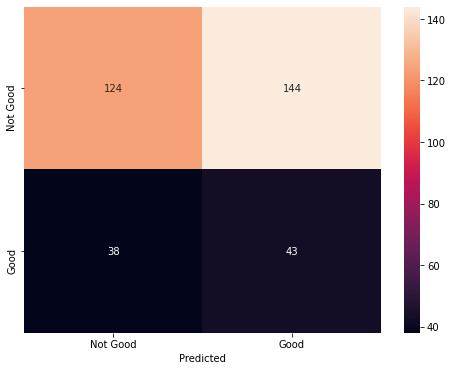

In [100]:
#plot confusion matrix for naive model

conf_mat = confusion_matrix(y_val, actual_pred_naive)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.xlabel('Predicted')

ax.xaxis.set_ticklabels(['Not Good', 'Good'])
ax.yaxis.set_ticklabels(['Not Good', 'Good'])


plt.show()

<font size="4">**4.1.3 Logistic Regression**</font>

In [101]:
#use sklearn pipeline
from sklearn.pipeline import Pipeline

#define classifier
clf = LogisticRegression(random_state = 48)

#define the pipeline - chain the preprocessor step and the classifier step
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [102]:
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('scaler', MinMaxScaler())]),
                                   ['NUM_SALARY_CHANGE_PREV_FY',
                                    'NUM_SALARY_CHANGE_CURR_FY',
                                    'NUM_ORG_CHANGE_PREV_FY',
                                    'NUM_ORG_CHANGE_CURR_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_CURR_FY',
                                    'NUM_MANAGER_CHANGE_PREV_FY',
                                    'NUM_MANAGER_CHANGE_CURR_FY',
                                    'NUM_JOB_CHANGE_PREV_FY',
                                    'NUM_JOB_...
                                    'TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                                    'TENURE_LATEST_HIRE_DATE_BAND_LIN',
                                    'JOB_TENURE_BAND_LIN',
          

In [103]:
#randomised search cv with 5 fold cross validation
skf = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)
#input the parameters for search space
param_grid = {
    'clf__C':[0.1, 0.5, 1.0, 5.0, 10.0],
    'clf__penalty':['l1','l2', 'elasticnet'],
    'clf__solver': ['lbfgs','liblinear', 'sag', 'saga'],
}

#create the logistic regression classifier object
#use scoring = 'f1_macro' as there are imbalanced classes
rscv_lr = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro', cv=skf, verbose=1, random_state=43)



In [104]:
%%time

#fit the lr_model with X_train and y_train data

lr_model = rscv_lr.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 1.43 s


In [105]:
#print best parameters and accuracy
print ('Best parameters found by randomised search are:', lr_model.best_params_)

print ('Best accuracy from randomised search is:', lr_model.best_score_)

Best parameters found by randomised search are: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 5.0}
Best accuracy from randomised search is: 0.5789694395374253


In [106]:
#use the lr_model to predict the testing data

y_pred_lr = lr_model.predict(X_test)


In [108]:
#inspect the classification metrics
print(metrics.classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80       249
           1       0.37      0.17      0.23       100

    accuracy                           0.68       349
   macro avg       0.55      0.53      0.51       349
weighted avg       0.62      0.68      0.64       349



In [109]:
%%time
# actual prediction with validation data

actual_pred_lr = lr_model.predict(X_val)

Wall time: 8.15 ms


In [110]:
#inspect the classification metrics
print(metrics.classification_report(y_val,actual_pred_lr))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       268
           1       0.37      0.21      0.27        81

    accuracy                           0.73       349
   macro avg       0.58      0.55      0.55       349
weighted avg       0.69      0.73      0.70       349



In [111]:
%%time
#get mean of cross validation scores with training data
skf = StratifiedKFold(n_splits=5, random_state = 45, shuffle=True)

lr_cross_val = cross_val_score(pipe, X_train, y_train, cv = skf, scoring='f1_macro')
lr_cross_val.mean()

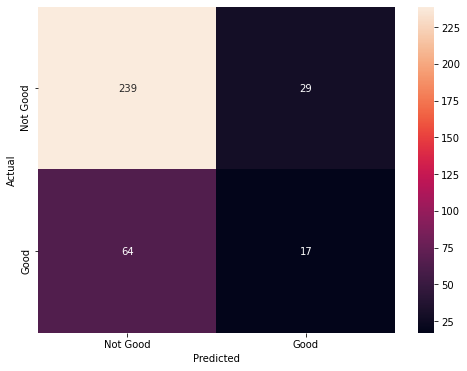

In [113]:
#plot confusion matrix

conf_mat = confusion_matrix(y_val, actual_pred_lr)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

ax.xaxis.set_ticklabels(['Not Good', 'Good'])
ax.yaxis.set_ticklabels(['Not Good', 'Good'])
plt.show()



<font size="3">**Note: Logistic regression does not have feature importance, so we use coefficients to assess which variables are more impactful to the model**</font>

https://stackoverflow.com/questions/66750706/sklearn-important-features-error-when-using-logistic-regression

In [114]:
#get the categorical features first

feat_names = (rscv_lr.best_estimator_.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(input_features=categorical_features))

#combine categorical features and numerical features and name it 'feat_names'
feat_names = np.concatenate([feat_names, numeric_features])

In [115]:
#get the coefficients from lr_model
lr_coefs = lr_model.best_estimator_.named_steps['clf'].coef_.squeeze().tolist()

#assign the feature names to the coefficients
labels_coef = list(zip(feat_names, lr_coefs))


In [116]:
#put the coefficients into a dataframe and rename the columns
lr_coef_data = pd.DataFrame(labels_coef)
lr_coef_data.rename(columns = {0:'Features', 1:'Coefficients'}, inplace = True)

lr_coef_data

,Features,Coefficients
0,SUBREGION_ANZ,-0.397674
1,SUBREGION_ASEAN,-0.188064
2,SUBREGION_China,-0.381320
3,SUBREGION_HKTW,-1.324832
4,SUBREGION_India,0.000000
5,SUBREGION_Japan,0.808693
6,SUBREGION_Korea,0.396118
7,COUNTRY_Australia,-1.103742
8,COUNTRY_Bangladesh,0.323238
9,COUNTRY_China,2.613623


In [117]:
#get the top 10 features based on absolute coefficient values
lr_feat_top10 = lr_coef_data.iloc[(-lr_coef_data['Coefficients'].abs()).argsort()].head(10)

In [118]:
lr_feat_top10

,Features,Coefficients
50,JOB_TENURE_BAND_LIN_4 to 5 yrs,-3.623349
42,TENURE_LATEST_HIRE_DATE_BAND_LIN_4 to 5 yrs,3.019743
44,TENURE_LATEST_HIRE_DATE_BAND_LIN_above 20 yrs,-2.642183
9,COUNTRY_China,2.613623
121,NATIONALITY_JP,2.540141
20,COUNTRY_Sri Lanka,2.125236
126,NATIONALITY_NL,2.108081
163,NUM_JOB_CHANGE_CURR_FY,-1.872084
54,TIME_SINCE_LAST_SALARY_INCR_BAND_2 to < 5 Yrs,-1.868560
107,NATIONALITY_BD,1.821388


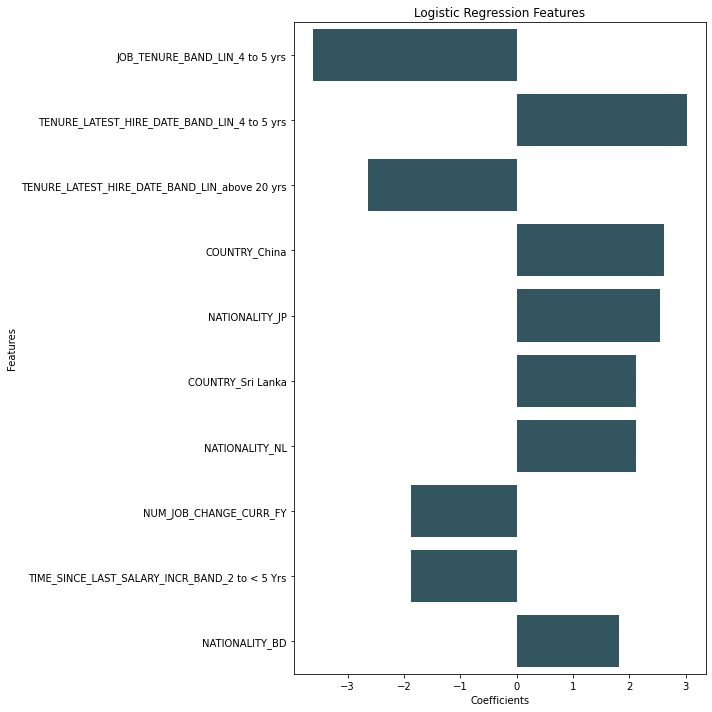

In [119]:
#plot the top 10 features in descending order
plt.figure(figsize=(10, 10))
sns.barplot(x="Coefficients", y="Features", data=lr_feat_top10, color="#2C5967")
plt.title('Logistic Regression Features')
plt.tight_layout()
plt.show()

## Modelling Step 4.2 Classification With Oversampling (SMOTENC)

<font size="3">**Note: SMOTENC is an oversampling technique commonly used to achieve balanced classes**</font>

<font size="4">**4.2.1 Training-Testing-Validation Split**</font>

In [120]:
df3 = df1.copy()

In [121]:
#convert categorical columns to string

cat_cols =  ['SUBREGION','COUNTRY','CAREER_LEVEL','TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
             'TENURE_LATEST_HIRE_DATE_BAND_LIN','JOB_TENURE_BAND_LIN','TIME_SINCE_LAST_SALARY_INCR_BAND',
             'GENDER','AGE_BAND','PRODUCT_LINE','PRODUCT_ASSOCIATION','RCODE_06','RCODE_07',
             'MANAGER_GENDER_DESC','NATIONALITY','HIRE_EVENT_DESCRIPTION',
             'MANAGER180_OVERALL_BAND_CURR_FY','ATTAINMENT_REP_LEVEL_BAND_PREV_FY','MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL']


df3[cat_cols] = df3[cat_cols].astype('str')

In [122]:
#get all the feature columns
feature_cols = ['SUBREGION','COUNTRY','CAREER_LEVEL','TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                'TENURE_LATEST_HIRE_DATE_BAND_LIN','JOB_TENURE_BAND_LIN','TIME_SINCE_LAST_SALARY_INCR_BAND',
                'GENDER','AGE_BAND','PRODUCT_LINE','PRODUCT_ASSOCIATION','RCODE_06','RCODE_07',
                'NATIONALITY','MANAGER_GENDER_DESC',
                'HIRE_EVENT_DESCRIPTION','NUM_SALARY_CHANGE_PREV_FY','NUM_SALARY_CHANGE_CURR_FY',
                'NUM_ORG_CHANGE_PREV_FY','NUM_ORG_CHANGE_CURR_FY','NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                'NUM_CAREER_LEVEL_CHANGE_CURR_FY','NUM_MANAGER_CHANGE_PREV_FY','NUM_MANAGER_CHANGE_CURR_FY',
                'NUM_JOB_CHANGE_PREV_FY','NUM_JOB_CHANGE_CURR_FY','NUM_LOCATION_CHANGE_PREV_FY','NUM_LOCATION_CHANGE_CURR_FY',
                'MANAGER180_OVERALL_BAND_CURR_FY','ATTAINMENT_REP_LEVEL_BAND_PREV_FY','MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL']


#define X and y

X = df3[feature_cols]
y = df3['ATTAINMENT_REP_LEVEL_BANDNUM_FY21']

In [123]:
#create an dataframe using selected feature columns
feature_df = df3[feature_cols]

In [124]:
#check datatypes
feature_df.dtypes

SUBREGION                                  object
COUNTRY                                    object
CAREER_LEVEL                               object
TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN    object
TENURE_LATEST_HIRE_DATE_BAND_LIN           object
JOB_TENURE_BAND_LIN                        object
TIME_SINCE_LAST_SALARY_INCR_BAND           object
GENDER                                     object
AGE_BAND                                   object
PRODUCT_LINE                               object
PRODUCT_ASSOCIATION                        object
RCODE_06                                   object
RCODE_07                                   object
NATIONALITY                                object
MANAGER_GENDER_DESC                        object
HIRE_EVENT_DESCRIPTION                     object
NUM_SALARY_CHANGE_PREV_FY                   int64
NUM_SALARY_CHANGE_CURR_FY                   int64
NUM_ORG_CHANGE_PREV_FY                      int64
NUM_ORG_CHANGE_CURR_FY                      int64


In [126]:
#use SMOTENC for oversampling
smote_nc = SMOTENC(categorical_features=[X.dtypes==object], random_state=21)


X_smote, y_smote = smote_nc.fit_resample(X.values, y)

In [127]:
#convert the X_smote array back to dataframe
X_smote = pd.DataFrame(data=X_smote, columns = X.columns)

In [128]:
print(X_smote.shape)
print(y_smote.shape)

(2560, 31)
(2560,)


In [129]:
#we split the data into 60% training data, 20% validation data and 20% testing data
# validation dataset is used to ensure that the model would not have seen the whole dataset


#split the dataset into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=32)

#split the training data again into training data and validation data. 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=32) # 0.25 x 0.8 = 0.2

In [130]:
X_train

,SUBREGION,COUNTRY,CAREER_LEVEL,TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN,TENURE_LATEST_HIRE_DATE_BAND_LIN,JOB_TENURE_BAND_LIN,TIME_SINCE_LAST_SALARY_INCR_BAND,GENDER,AGE_BAND,PRODUCT_LINE,PRODUCT_ASSOCIATION,RCODE_06,RCODE_07,NATIONALITY,MANAGER_GENDER_DESC,HIRE_EVENT_DESCRIPTION,NUM_SALARY_CHANGE_PREV_FY,NUM_SALARY_CHANGE_CURR_FY,NUM_ORG_CHANGE_PREV_FY,NUM_ORG_CHANGE_CURR_FY,NUM_CAREER_LEVEL_CHANGE_PREV_FY,NUM_CAREER_LEVEL_CHANGE_CURR_FY,NUM_MANAGER_CHANGE_PREV_FY,NUM_MANAGER_CHANGE_CURR_FY,NUM_JOB_CHANGE_PREV_FY,NUM_JOB_CHANGE_CURR_FY,NUM_LOCATION_CHANGE_PREV_FY,NUM_LOCATION_CHANGE_CURR_FY,MANAGER180_OVERALL_BAND_CURR_FY,ATTAINMENT_REP_LEVEL_BAND_PREV_FY,MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL
1020,Japan,Japan,IC3,5 to 10 yrs,5 to 10 yrs,1 to 2 yrs,2 to < 5 Yrs,M,40-49 Years,Hardware,Combo Hardware,Japan Hardware,Japan Systems,JP,Male,Unspecified,0.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,nan,Avg,Naturalised Manager
112,ANZ,Australia,IC3,1 to 2 yrs,1 to 2 yrs,1 to 2 yrs,1 to < 2 Yrs,M,30-39 Years,Tech,Tech Cloud,APAC Software Sales,APAC TECH LICENSE,AU,Male,HIRE EVENT,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nan,Poor,Internally Promoted Manager
651,ASEAN,Philippines,IC4,1 to 2 yrs,1 to 2 yrs,1 to 2 yrs,1 to < 2 Yrs,F,50-59 Years,Apps,ERP,APAC Software Sales,APAC APPS LICENSE,PH,Female,HIRE EVENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Very High,Poor,Naturalised Manager
2129,Korea,South Korea,IC4,5 to 10 yrs,5 to 10 yrs,5 to 10 yrs,<1 Yr,M,40-49 Years,Tech,Tech Cloud,APAC Software Sales,APAC TECH LICENSE,KR,Male,Unspecified,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,Very High,Great,Internally Promoted Manager
1291,India,India,IC4,5 to 10 yrs,5 to 10 yrs,5 to 10 yrs,2 to < 5 Yrs,M,40-49 Years,Tech,Tech License,APAC Software Sales,APAC TECH LICENSE,IN,Male,HIRE EVENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Very High,Avg,Internally Promoted Manager
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,India,India,IC3,5 to 10 yrs,5 to 10 yrs,3 to 4 yrs,5 to < 10 Yrs,M,40-49 Years,Apps,Combo Front Office,APAC Software Sales,APAC APPS LICENSE,IN,Male,HIRE EVENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,Poor,Naturalised Manager
2465,Japan,Japan,IC3,5 to 10 yrs,5 to 10 yrs,2 to 3 yrs,2 to < 5 Yrs,M,30-39 Years,Tech,Tech Cloud,Japan Software Sales,JP - CTBU,JP,Male,HIRE EVENT,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.143668,Very High,Great,Internally Promoted Manager
2125,ASEAN,China,IC4,5 to 10 yrs,5 to 10 yrs,5 to 10 yrs,<1 Yr,M,20-29 years,Tech,Tech Combo,APAC Software Sales,APAC TECH LICENSE,HK,Male,HIRE EVENT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,Good,Internally Promoted Manager
0,India,India,IC4,0 to 1 yr,0 to 1 yr,0 to 1 yr,<1 Yr,M,30-39 Years,Tech,Tech Cloud,APAC Software Sales,APAC TECH LICENSE,IN,Male,TRANSFER EVENT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,Poor,Externally Hired Manager


In [131]:
#print(df2.iloc[1122])


In [132]:
y_test

2460    1
1519    0
69      1
2170    1
1471    0
1425    0
1743    1
770     1
2345    1
2550    1
1671    1
750     0
877     0
2268    1
238     0
132     0
2005    1
1303    0
1629    0
1217    0
310     0
123     0
1147    0
324     0
2559    1
1581    0
1779    1
401     0
603     0
383     0
2050    1
1901    1
1470    0
2029    1
1437    1
325     0
2013    1
2135    1
1120    0
1082    1
2070    1
995     0
1141    0
809     0
1496    0
1215    0
1018    1
1411    0
1426    1
2355    1
821     1
670     1
567     1
920     0
673     1
834     0
2229    1
158     0
209     1
2138    1
520     0
1650    1
1865    1
98      1
1751    1
1787    1
2556    1
2150    1
549     1
1492    0
1104    0
1960    1
1051    0
1290    0
754     0
1534    0
1206    1
1272    0
1929    1
1234    0
760     1
1971    1
1170    0
7       0
2216    1
1774    1
642     0
1639    1
2463    1
2387    1
1395    0
1627    0
233     0
2139    1
1850    1
1817    1
332     0
1491    0
508     1
913     0


<font size="4">**4.2.2 Logistic Regression with Oversampling**</font>

In [570]:
#use sklearn pipeline
from sklearn.pipeline import Pipeline

#define the numeric features
numeric_features = ['NUM_SALARY_CHANGE_PREV_FY','NUM_SALARY_CHANGE_CURR_FY','NUM_ORG_CHANGE_PREV_FY','NUM_ORG_CHANGE_CURR_FY',
                    'NUM_CAREER_LEVEL_CHANGE_PREV_FY','NUM_CAREER_LEVEL_CHANGE_CURR_FY','NUM_MANAGER_CHANGE_PREV_FY',
                    'NUM_MANAGER_CHANGE_CURR_FY','NUM_JOB_CHANGE_PREV_FY','NUM_JOB_CHANGE_CURR_FY',
                    'NUM_LOCATION_CHANGE_PREV_FY','NUM_LOCATION_CHANGE_CURR_FY']

#create a pipeline for numeric transformer
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

In [571]:
#define the categorical features
categorical_features = ['SUBREGION','COUNTRY','CAREER_LEVEL','TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                        'TENURE_LATEST_HIRE_DATE_BAND_LIN','JOB_TENURE_BAND_LIN','TIME_SINCE_LAST_SALARY_INCR_BAND',
                        'GENDER','AGE_BAND','PRODUCT_LINE','PRODUCT_ASSOCIATION','RCODE_06','RCODE_07',
                        'MANAGER_GENDER_DESC','NATIONALITY',
                        'HIRE_EVENT_DESCRIPTION','MANAGER180_OVERALL_BAND_CURR_FY','ATTAINMENT_REP_LEVEL_BAND_PREV_FY',
                        'MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL']


#create a pipeline for categorical transformer
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

In [572]:
#define the preprocessor step using columntransformer for both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [573]:
#define classifier
clf = LogisticRegression(class_weight = 'balanced',random_state = 48)


#define the whole pipeline - chain the column transformer and the classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [574]:
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('scaler', MinMaxScaler())]),
                                   ['NUM_SALARY_CHANGE_PREV_FY',
                                    'NUM_SALARY_CHANGE_CURR_FY',
                                    'NUM_ORG_CHANGE_PREV_FY',
                                    'NUM_ORG_CHANGE_CURR_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_CURR_FY',
                                    'NUM_MANAGER_CHANGE_PREV_FY',
                                    'NUM_MANAGER_CHANGE_CURR_FY',
                                    'NUM_JOB_CHANGE_PREV_FY',
                                    'NUM_JOB_...
                                    'TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                                    'TENURE_LATEST_HIRE_DATE_BAND_LIN',
                                    'JOB_TENURE_BAND_LIN',
          

In [575]:
#randomised search cv with 5 fold cross validation
skf = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)
#input the parameters for search space
param_grid = {
    'clf__C':[0.1, 0.5, 1.0, 5.0, 10.0],
    'clf__penalty':['l1','l2', 'elasticnet'],
    'clf__solver': ['lbfgs','liblinear', 'sag', 'saga'],
}

#create the logistic regression classifier object
#use scoring = 'f1_macro' as there are imbalanced classes
rscv_lr2 = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro', cv=skf, verbose=1, random_state=42)

In [576]:
%%time

#fit the lr_model2 with X_train and y_train data

lr_model2 = rscv_lr2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 1.26 s


In [577]:
#save the model
pkl_filename = 'fy21_lr_rscv_binarygoodnotgood_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr_model2, file)

In [135]:
#load the model if needed to save time
with open ('fy21_lr_rscv_binarygoodnotgood_model.pkl','rb') as file:
    lr_model2 = pickle.load(file)

In [136]:
#print the best parameters and accuracy
print ('Best parameters found by randomised search are:',lr_model2.best_params_)

print ('Best accuracy from randomised search is:', lr_model2.best_score_)

Best parameters found by randomised search are: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 0.5}
Best accuracy from randomised search is: 0.7080765540924494


In [ ]:
%%time
#prediction on testing data
y_pred_lr2 = lr_model2.predict(X_test)

In [137]:
#inspect classification metrics
print(metrics.classification_report(y_test,y_pred_lr2))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       260
           1       0.73      0.74      0.73       252

    accuracy                           0.73       512
   macro avg       0.73      0.73      0.73       512
weighted avg       0.73      0.73      0.73       512



In [138]:
%%time
# actual prediction with validation data
actual_pred_lr2 = lr_model2.predict(X_val)

Wall time: 8.95 ms


In [139]:
#inspect classsification metrics
print(metrics.classification_report(y_val,actual_pred_lr2))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75       260
           1       0.74      0.73      0.74       252

    accuracy                           0.74       512
   macro avg       0.74      0.74      0.74       512
weighted avg       0.74      0.74      0.74       512



In [140]:
#save the predicted model
pkl_filename = 'fy21_lr2predictionmodel.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(actual_pred_lr2, file)

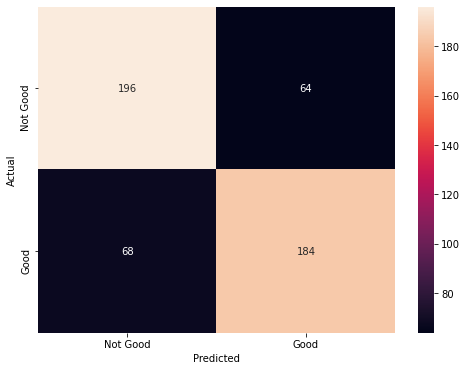

In [141]:
#plot confusion matrix

conf_mat = confusion_matrix(y_val, actual_pred_lr2)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d')

ax.xaxis.set_ticklabels(['Not Good', 'Good'])
ax.yaxis.set_ticklabels(['Not Good', 'Good'])


plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [585]:
%%time
#get the cross validation score for training data
skf = StratifiedKFold(n_splits=5, random_state = 45, shuffle=True)

lr_cross_val2 = cross_val_score(lr_model2, X_train, y_train, cv = skf, scoring='f1_macro')
print(lr_cross_val2.mean())


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7080765540924494
Wall time: 5.37 s


In [586]:
#get the categorical features first

feat_names2 = (rscv_lr2.best_estimator_.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(input_features=categorical_features))

#combine categorical features and numerical features and name it 'feat_names'
feat_names2 = np.concatenate([feat_names2, numeric_features])


In [587]:
#get the coefficients from lr_model2
lr_coefs2 = lr_model2.best_estimator_.named_steps['clf'].coef_.squeeze().tolist()

#assign the feature names to the coefficients
labels_coef2 = list(zip(feat_names2, lr_coefs2))


In [588]:
#put the coefficients into a dataframe and rename the columns
lr_coef_data2 = pd.DataFrame(labels_coef2)
lr_coef_data2.rename(columns = {0:'Features', 1:'Coefficients'}, inplace = True)

lr_coef_data2

,Features,Coefficients
0,SUBREGION_ANZ,0.000000
1,SUBREGION_ASEAN,0.000000
2,SUBREGION_China,-0.567180
3,SUBREGION_HKTW,0.000000
4,SUBREGION_India,0.000000
5,SUBREGION_Japan,0.420957
6,SUBREGION_Korea,0.138312
7,COUNTRY_Australia,-1.249066
8,COUNTRY_Bangladesh,0.000000
9,COUNTRY_China,0.000000


In [589]:
#get the top 10 features based on absolute coefficient values
lr2_feat_top10 = lr_coef_data2.iloc[(-lr_coef_data2['Coefficients'].abs()).argsort()].head(10)

In [590]:
lr2_feat_top10

,Features,Coefficients
7,COUNTRY_Australia,-1.249066
75,PRODUCT_ASSOCIATION_Eng Systems,-1.177602
111,NATIONALITY_CN,-1.119053
68,PRODUCT_LINE_Others,-1.111644
154,NUM_SALARY_CHANGE_PREV_FY,-0.984919
48,JOB_TENURE_BAND_LIN_10 to 20 yrs,0.907884
92,RCODE_07_APAC TECH LICENSE,0.868986
83,PRODUCT_ASSOCIATION_nan,-0.725107
98,RCODE_07_JP - CTBU,-0.724924
150,MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL_Internally...,-0.684560


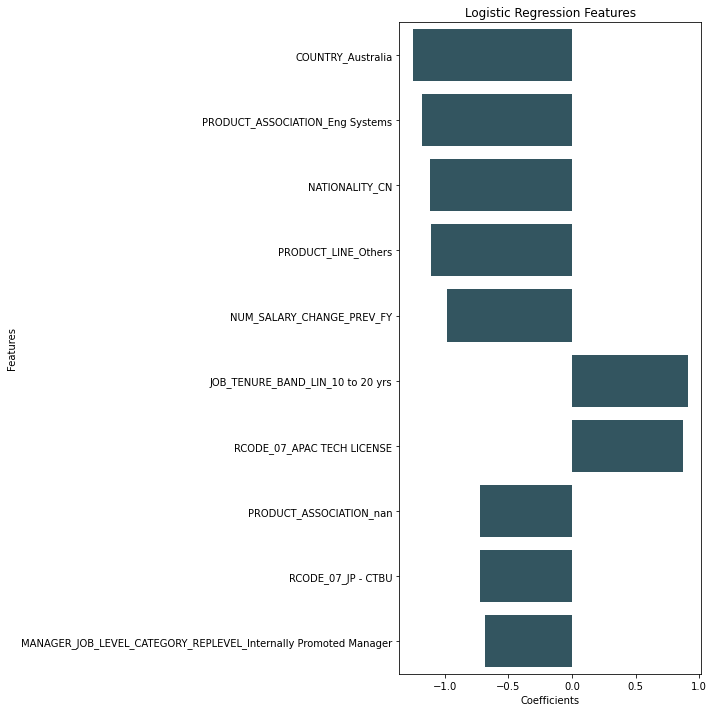

In [591]:
#plot the top 10 features in descending order
plt.figure(figsize=(10, 10))
features = sns.barplot(x="Coefficients", y="Features", data=lr2_feat_top10, color="#2C5967")
plt.title('Logistic Regression Features')
plt.tight_layout()
plt.show()


figure = features.get_figure()    
figure.savefig('LR_features.png', dpi=400)

<font size="4">**4.2.3.1 Random Forest with Oversampling**</font>

In [596]:
#use sklearn pipeline
from sklearn.pipeline import Pipeline

#define classifier
clf = RandomForestClassifier(random_state = 48)

#define the pipeline - chain the preprocessor step and the classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [597]:
#check pipe steps
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('scaler', MinMaxScaler())]),
                                   ['NUM_SALARY_CHANGE_PREV_FY',
                                    'NUM_SALARY_CHANGE_CURR_FY',
                                    'NUM_ORG_CHANGE_PREV_FY',
                                    'NUM_ORG_CHANGE_CURR_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_CURR_FY',
                                    'NUM_MANAGER_CHANGE_PREV_FY',
                                    'NUM_MANAGER_CHANGE_CURR_FY',
                                    'NUM_JOB_CHANGE_PREV_FY',
                                    'NUM_JOB_...
                                    'TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                                    'TENURE_LATEST_HIRE_DATE_BAND_LIN',
                                    'JOB_TENURE_BAND_LIN',
          

In [598]:
#randomised search with 5 fold cross validation

skf = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
#input the parameters for search space
param_grid = {
    'clf__n_estimators':[500, 1000, 5000],
    'clf__max_features':['sqrt','log2'],
    'clf__max_depth': [5, 10, 15, 20],
    'clf__min_samples_split': [2,5,10,15],
    'clf__min_samples_leaf': [2,5,10,15],
    'clf__bootstrap': [True, False],
    'clf__criterion': ['gini','entropy']
}

#create the random forest classifier object
rscv_rf = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro', cv = skf, verbose=1, random_state=24)

In [599]:
%%time

#fit the rf_model with X_train and y_train data
rf_model = rscv_rf.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 2min 55s


In [600]:
#save the model
pkl_filename = 'fy21_rf_rscv_binarygoodnotgood_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_model, file)

In [142]:
#load the model if needed to save time
with open ('fy21_rf_rscv_binarygoodnotgood_model.pkl','rb') as file:
    rf_model = pickle.load(file)

In [143]:
#print best parameters and accuracy
print ('Best parameters found by randomised search are:', rf_model.best_params_)

print ('Best accuracy from randomised search is:', rf_model.best_score_)

Best parameters found by randomised search are: {'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 15, 'clf__criterion': 'gini', 'clf__bootstrap': True}
Best accuracy from randomised search is: 0.7660838261272098


In [ ]:
#prediction on testing data
pred_rf = rf_model.predict(X_test)

In [144]:
#inspect classification metrics
print(metrics.classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       260
           1       0.76      0.76      0.76       252

    accuracy                           0.76       512
   macro avg       0.76      0.76      0.76       512
weighted avg       0.76      0.76      0.76       512



In [145]:
%%time
# actual prediction with validation data

actual_pred_rf = rf_model.predict(X_val)

Wall time: 79.8 ms


In [146]:
#inspect classification metrics
print(metrics.classification_report(y_val,actual_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       260
           1       0.79      0.79      0.79       252

    accuracy                           0.79       512
   macro avg       0.79      0.79      0.79       512
weighted avg       0.79      0.79      0.79       512



In [147]:
#save the predicted model
pkl_filename = 'fy21_rfpredictionmodel.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(actual_pred_rf, file)

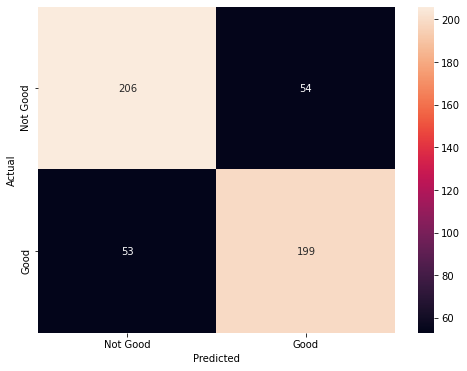

In [148]:
#plot confusion matrix
conf_mat2 = confusion_matrix(y_val, actual_pred_rf)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat2, annot=True, fmt='d')

ax.xaxis.set_ticklabels(['Not Good', 'Good'])
ax.yaxis.set_ticklabels(['Not Good', 'Good'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [463]:
%%time

#get the cross validation score on the X_train and y_train data
skf = StratifiedKFold(n_splits=5, random_state = 45, shuffle=True)

rf_cross_val = cross_val_score(rf_model, X_train, y_train, cv = skf, scoring='f1_macro')

print(rf_cross_val.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7675794852756506
Wall time: 9min 45s


<font size="3">**Note: Permutation based feature importance was used to select features that contributed most to algorithm accuracy, more info here:**</font>

https://explained.ai/rf-importance/index.html

In [603]:
# The Permutation based feature importance is used here

from sklearn.inspection import permutation_importance

#use the function on the validation data
imps = permutation_importance(rf_model, X_val, y_val, n_repeats=30)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

#print the feature ranking
print("Feature ranking:")
for f in range(X_val.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. MANAGER180_OVERALL_BAND_CURR_FY (0.052203)
2. MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL (0.022400)
3. GENDER (0.015231)
4. AGE_BAND (0.012641)
5. TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN (0.012471)
6. ATTAINMENT_REP_LEVEL_BAND_PREV_FY (0.011886)
7. CAREER_LEVEL (0.009828)
8. TIME_SINCE_LAST_SALARY_INCR_BAND (0.009765)
9. PRODUCT_LINE (0.009242)
10. PRODUCT_ASSOCIATION (0.008339)
11. NATIONALITY (0.008236)
12. NUM_MANAGER_CHANGE_CURR_FY (0.007347)
13. RCODE_07 (0.007036)
14. COUNTRY (0.006130)
15. TENURE_LATEST_HIRE_DATE_BAND_LIN (0.005633)
16. RCODE_06 (0.005097)
17. NUM_MANAGER_CHANGE_PREV_FY (0.005079)
18. SUBREGION (0.004733)
19. JOB_TENURE_BAND_LIN (0.003692)
20. NUM_JOB_CHANGE_CURR_FY (0.003059)
21. HIRE_EVENT_DESCRIPTION (0.002922)
22. NUM_SALARY_CHANGE_CURR_FY (0.000262)
23. NUM_CAREER_LEVEL_CHANGE_CURR_FY (0.000257)
24. NUM_LOCATION_CHANGE_CURR_FY (0.000069)
25. NUM_CAREER_LEVEL_CHANGE_PREV_FY (-0.000065)
26. NUM_SALARY_CHANGE_PREV_FY (-0.000196)
27. NUM_JOB_CHANGE

In [604]:
#place the features into a dataframe and rename the columns

importances_rf = list(zip(importances, X.columns))

rf_perm_impt = pd.DataFrame(importances_rf)

rf_perm_impt.rename(columns = {0:'Impt Values', 1:'Features'}, inplace = True)

In [605]:
#get the top 10 features

rf_perm_top10 = rf_perm_impt.sort_values(by=['Impt Values'], ascending=False).head(10)

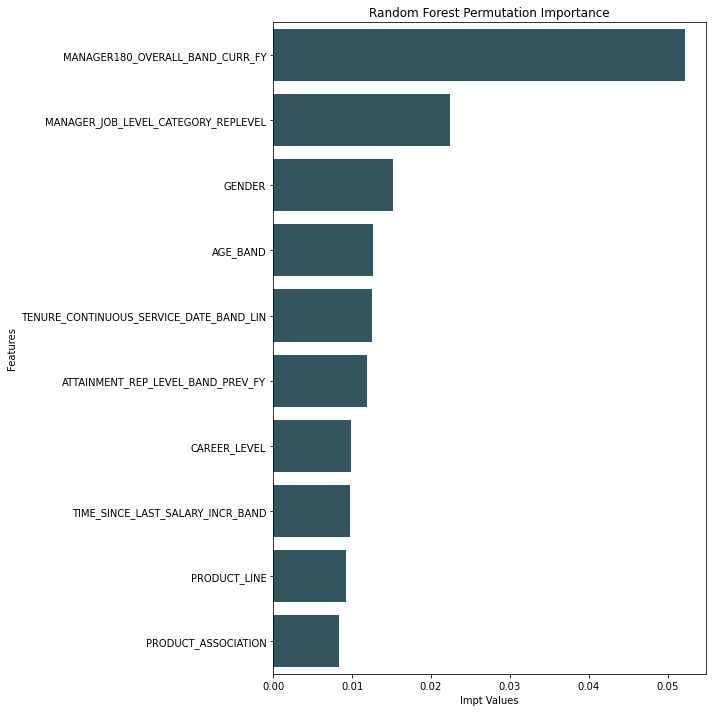

In [606]:
#plot the top 10 features in descending order

plt.figure(figsize=(10, 10))
features = sns.barplot(x="Impt Values", y="Features", data= rf_perm_top10.sort_values(by="Impt Values", ascending=False), color="#2C5967")
plt.title('Random Forest Permutation Importance')
plt.tight_layout()
plt.show()

figure = features.get_figure()
#save the figure for use
figure.savefig('RF_features.png', dpi=400)

<font size="4">**4.2.3.2 Visualising a random forest for explanation purposes (Optional to run)**</font>

In [615]:
#use sklearn pipeline
from sklearn.pipeline import Pipeline

#define classifier
clf = RandomForestClassifier(random_state = 48)

#define the pipeline - chain the preprocessor step and the classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [616]:
#randomised search with 5 fold cross validation
skf = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

#input the parameters for search space, the depth of the tree is kept short to aid in explanation
param_grid = {
    'clf__n_estimators':[500, 1000, 5000],
    'clf__max_features':['sqrt','log2'],
    'clf__max_depth': [4],
    'clf__min_samples_split': [2,5,10,15],
    'clf__min_samples_leaf': [2,5,10,15],
    'clf__bootstrap': [True, False],
    'clf__criterion': ['gini','entropy']
}

#create the random forest classifier object
rscv_rf_viz = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro', cv=skf, verbose=1, random_state=42)

In [617]:
%%time

#fit the rf_model_viz with X_train and y_train data

rf_model_viz = rscv_rf_viz.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 1min 54s


In [618]:
#print the best parameters and accuracy
print ('Best parameters found by randomised search are:', rf_model_viz.best_params_)

print ('Best accuracy from randomised search is:', rf_model_viz.best_score_)

Best parameters found by randomised search are: {'clf__n_estimators': 5000, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 15, 'clf__max_features': 'sqrt', 'clf__max_depth': 4, 'clf__criterion': 'entropy', 'clf__bootstrap': False}
Best accuracy from randomised search is: 0.7047016872511539


In [ ]:
#prediction on testing data first
y_pred_viz = rf_model_viz.predict(X_test)

In [619]:
#inspect classification metrics
print(metrics.classification_report(y_test,y_pred_viz))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70       260
           1       0.69      0.75      0.72       252

    accuracy                           0.71       512
   macro avg       0.71      0.71      0.71       512
weighted avg       0.71      0.71      0.71       512



In [620]:
%%time
# actual prediction with validation data

actual_pred_rf_viz = rf_model_viz.predict(X_val)

Wall time: 610 ms


In [621]:
#inspect classification metrics
print(metrics.classification_report(y_val,actual_pred_rf_viz))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       260
           1       0.70      0.71      0.71       252

    accuracy                           0.71       512
   macro avg       0.71      0.71      0.71       512
weighted avg       0.71      0.71      0.71       512



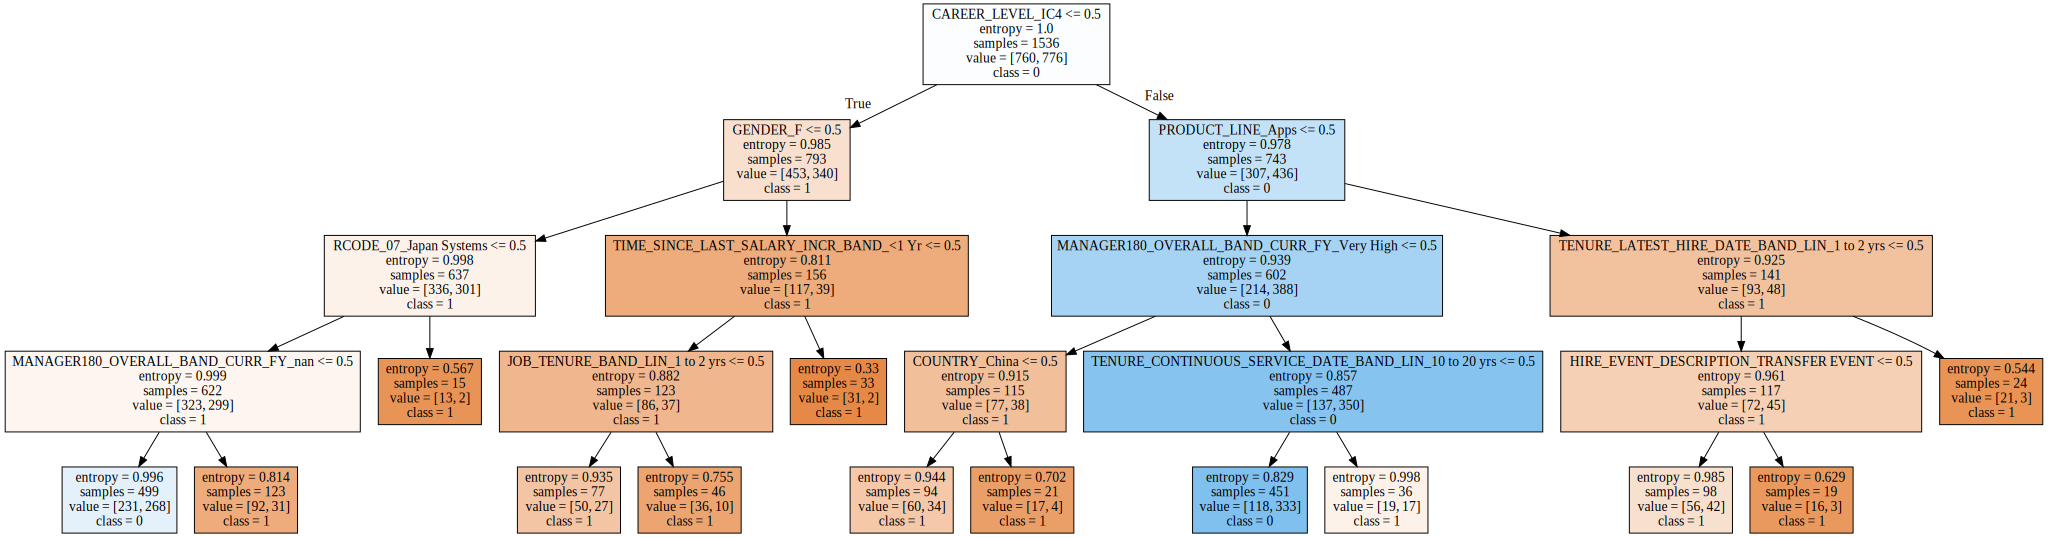

In [622]:
#use graphviz package for visualisation
import graphviz
# DOT data
dot_data = tree.export_graphviz(rscv_rf_viz.best_estimator_.named_steps['clf'].estimators_[2], out_file=None, 
                                feature_names=fn,  
                                class_names=cn,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [623]:
#render and save the image
graph.render("decision_tree_graphivz")
'fy21_decision_tree_graphivz(not good vs good).png'


'fy21_decision_tree_graphivz(not good vs good).png'

<font size="3">**Note: Refer to the following link on how to interpret the decision tree output**</font>

https://stackoverflow.com/questions/47503575/what-do-the-values-that-graphviz-renders-inside-each-node-of-a-decision-tree-m

<font size="4">**4.3 Light Gradient Boosting Machine with Oversampling**</font>

In [624]:
#use sklearn pipeline
from sklearn.pipeline import Pipeline

#define classifier
clf = LGBMClassifier(objective = 'binary', metric = 'binary_logloss',random_state = 48)

#define the pipeline - chain the preprocessor step and the classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [625]:
#check pipe steps
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('scaler', MinMaxScaler())]),
                                   ['NUM_SALARY_CHANGE_PREV_FY',
                                    'NUM_SALARY_CHANGE_CURR_FY',
                                    'NUM_ORG_CHANGE_PREV_FY',
                                    'NUM_ORG_CHANGE_CURR_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_CURR_FY',
                                    'NUM_MANAGER_CHANGE_PREV_FY',
                                    'NUM_MANAGER_CHANGE_CURR_FY',
                                    'NUM_JOB_CHANGE_PREV_FY',
                                    'NUM_JOB_...
                                    'TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                                    'TENURE_LATEST_HIRE_DATE_BAND_LIN',
                                    'JOB_TENURE_BAND_LIN',
          

In [626]:
#randomised search with 5 fold cross validation

#input the parameters for search space

skf = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)

param_grid = {
    'clf__boosting_type':['gbdt','dart'],
    'clf__n_estimators':[500, 1000],
    'clf__learning_rate':[0.05, 0.1, 0.5],
    'clf__max_depth': [10, 20, 30],
    'clf__num_leaves': [1000, 2000],

}

#create the light gbm classifier object
#f1 macro is used for imbalanced datasets
rscv_lgbm = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro',random_state=22, cv=skf, verbose=1)



In [627]:
%%time

#fit the lgbm_model with X_train and y_train data

lgbm_model = rscv_lgbm.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 1min 55s


In [628]:
#save the model
pkl_filename = 'fy21_lgbm_rscv_binarygoodnotgood_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(lgbm_model, file)

In [149]:
#load the model if needed to save time
with open ('fy21_lgbm_rscv_binarygoodnotgood_model.pkl','rb') as file:
    lgbm_model = pickle.load(file)

In [150]:
#print best parameters and accuracy
print ('Best parameters found by randomised search are:', lgbm_model.best_params_)

print ('Best accuracy from randomised search is:', lgbm_model.best_score_)

Best parameters found by randomised search are: {'clf__num_leaves': 1000, 'clf__n_estimators': 1000, 'clf__max_depth': 30, 'clf__learning_rate': 0.1, 'clf__boosting_type': 'gbdt'}
Best accuracy from randomised search is: 0.7678807619272018


In [151]:
#predict the test data first
y_pred_lgbm = lgbm_model.predict(X_test)


In [152]:
#inspect classification metrics
print(metrics.classification_report(y_test,y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       260
           1       0.75      0.75      0.75       252

    accuracy                           0.76       512
   macro avg       0.76      0.76      0.76       512
weighted avg       0.76      0.76      0.76       512



In [153]:
%%time
# actual prediction with validation daata

actual_pred_lgbm = lgbm_model.predict(X_val)

Wall time: 23 ms


In [154]:
#inspect classification metrics
print(metrics.classification_report(y_val,actual_pred_lgbm))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       260
           1       0.78      0.79      0.78       252

    accuracy                           0.79       512
   macro avg       0.79      0.79      0.79       512
weighted avg       0.79      0.79      0.79       512



In [155]:
#save the predicted model
pkl_filename = 'fy21_lgbmpredictionmodel.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(actual_pred_lgbm, file)

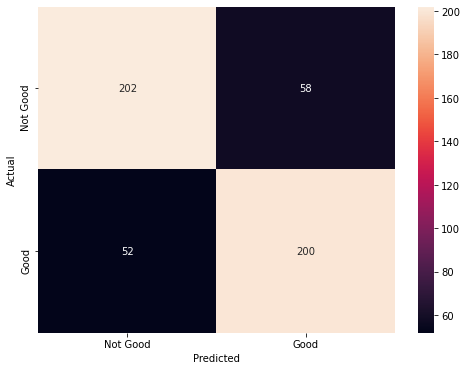

In [156]:
#plot confusion matrix

conf_mat = confusion_matrix(y_val, actual_pred_lgbm)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

ax.xaxis.set_ticklabels(['Not Good', 'Good'])
ax.yaxis.set_ticklabels(['Not Good', 'Good'])
plt.show()

In [739]:
%%time

#get the cross validation score on the X_train and y_train data
skf = StratifiedKFold(n_splits=5, random_state = 45, shuffle=True)

lgbm_cross_val = cross_val_score(lgbm_model, X_train, y_train, cv = skf, scoring='f1_macro')
print(lgbm_cross_val.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7863243137450202
Wall time: 7min 54s


In [633]:
# The Permutation based feature importance is used here
from sklearn.inspection import permutation_importance

#use the permutation importance function on validation data
imps = permutation_importance(lgbm_model, X_val, y_val, n_repeats=13)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_val.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. ATTAINMENT_REP_LEVEL_BAND_PREV_FY (0.032085)
2. NUM_MANAGER_CHANGE_PREV_FY (0.029601)
3. NATIONALITY (0.028564)
4. MANAGER180_OVERALL_BAND_CURR_FY (0.027492)
5. PRODUCT_ASSOCIATION (0.022932)
6. CAREER_LEVEL (0.022750)
7. TIME_SINCE_LAST_SALARY_INCR_BAND (0.020519)
8. NUM_MANAGER_CHANGE_CURR_FY (0.019331)
9. GENDER (0.015046)
10. MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL (0.014443)
11. AGE_BAND (0.014300)
12. TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN (0.010845)
13. JOB_TENURE_BAND_LIN (0.010083)
14. NUM_ORG_CHANGE_CURR_FY (0.009951)
15. COUNTRY (0.009170)
16. MANAGER_GENDER_DESC (0.008266)
17. SUBREGION (0.007416)
18. RCODE_07 (0.006912)
19. NUM_LOCATION_CHANGE_PREV_FY (0.006471)
20. TENURE_LATEST_HIRE_DATE_BAND_LIN (0.006317)
21. RCODE_06 (0.004959)
22. NUM_LOCATION_CHANGE_CURR_FY (0.004359)
23. NUM_ORG_CHANGE_PREV_FY (0.002586)
24. HIRE_EVENT_DESCRIPTION (0.002298)
25. NUM_SALARY_CHANGE_CURR_FY (0.001953)
26. NUM_CAREER_LEVEL_CHANGE_CURR_FY (0.001350)
27. NUM_SALARY_CHANG

In [634]:
#place the features into a dataframe and rename the columns

importances_lgbm = list(zip(importances, X.columns))

lgbm_perm_impt = pd.DataFrame(importances_lgbm)

lgbm_perm_impt.rename(columns = {0:'Impt Values', 1:'Features'}, inplace = True)

In [635]:
#get the top 10 features

lgbm_perm_top10 = lgbm_perm_impt.sort_values(by=['Impt Values'], ascending=False).head(10)

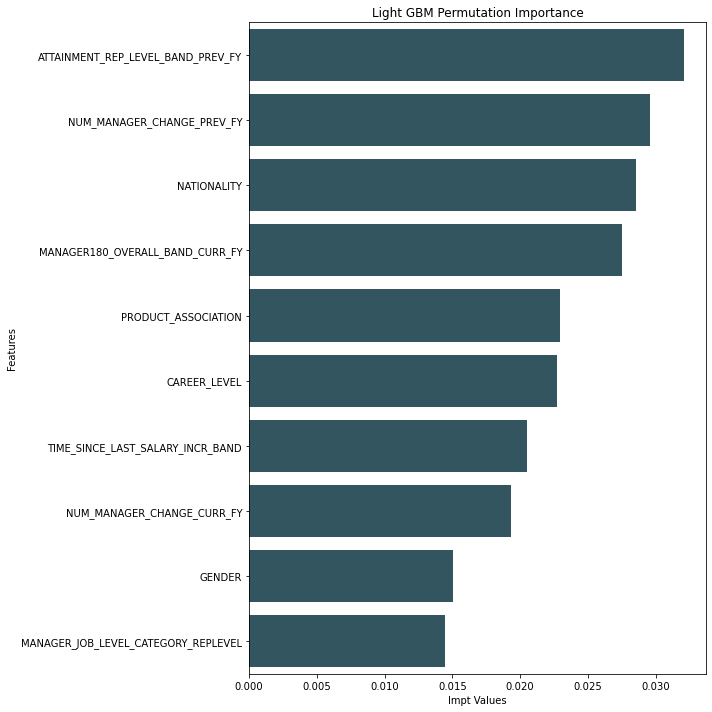

In [636]:
#plot the top 10 features in descending order

plt.figure(figsize=(10, 10))
features = sns.barplot(x="Impt Values", y="Features", data= lgbm_perm_top10.sort_values(by="Impt Values", ascending=False), color="#2C5967")
plt.title('Light GBM Permutation Importance')
plt.tight_layout()
plt.show()


figure = features.get_figure()
#save the chart for use
figure.savefig('LGBM_features.png', dpi=400)

<font size="4">**4.4 Support Vector Machine with Oversampling**</font>

In [221]:
#use sklearn pipeline

from sklearn.pipeline import Pipeline

#define classifier
#probability is set to True so that the predict_proba function could be used later
clf = SVC(probability=True,random_state = 48)

#define the pipeline - chain the preprocessor step and the classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [222]:
#check pipe steps
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('scaler', MinMaxScaler())]),
                                   ['NUM_SALARY_CHANGE_PREV_FY',
                                    'NUM_SALARY_CHANGE_CURR_FY',
                                    'NUM_ORG_CHANGE_PREV_FY',
                                    'NUM_ORG_CHANGE_CURR_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_CURR_FY',
                                    'NUM_MANAGER_CHANGE_PREV_FY',
                                    'NUM_MANAGER_CHANGE_CURR_FY',
                                    'NUM_JOB_CHANGE_PREV_FY',
                                    'NUM_JOB_...
                                    'TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                                    'TENURE_LATEST_HIRE_DATE_BAND_LIN',
                                    'JOB_TENURE_BAND_LIN',
          

In [223]:
#randomised search with 5 fold cross validation
skf = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)
#input the parameters for search space

param_grid = {'clf__C': [0.1, 1, 10, 100, 1000], 
              'clf__gamma': [0.001, 0.01, 0.1, 1],
              'clf__kernel': ['linear','poly','rbf','sigmoid'],
              'clf__degree':[1,3]

}

#create the support vector machine classifier object
rscv_svc = RandomizedSearchCV(estimator = pipe, param_distributions=param_grid, scoring='f1_macro',cv=skf, random_state=22, verbose=1)



In [224]:
%%time

#fit the svc_model with X_train and y_train data
svc_model = rscv_svc.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 59.4 s


In [225]:
#save the model
pkl_filename = 'fy21_svc_rscv_binarygoodnotgood_model.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc_model, file)

In [226]:
#load the model if needed to save time
with open ('fy21_svc_rscv_binarygoodnotgood_model.pkl','rb') as file:
    svc_model = pickle.load(file)

In [227]:
#print the best parameters and accuracy
print ('Best parameters found by randomised search are:', svc_model.best_params_)

print ('Best accuracy from randomised search is:', svc_model.best_score_)

Best parameters found by randomised search are: {'clf__kernel': 'poly', 'clf__gamma': 1, 'clf__degree': 3, 'clf__C': 1000}
Best accuracy from randomised search is: 0.7449589438417745


In [228]:
#predict the test data first
y_pred_svc = svc_model.predict(X_test)

In [229]:
#inspect classification metrics
print(metrics.classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75       260
           1       0.74      0.73      0.74       252

    accuracy                           0.74       512
   macro avg       0.74      0.74      0.74       512
weighted avg       0.74      0.74      0.74       512



In [230]:
%%time
# actual prediction with validation data

actual_pred_svc = svc_model.predict(X_val)

Wall time: 58.9 ms


In [231]:
#inspect classification metrics
print(metrics.classification_report(y_val,actual_pred_svc))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       260
           1       0.75      0.77      0.76       252

    accuracy                           0.76       512
   macro avg       0.76      0.76      0.76       512
weighted avg       0.76      0.76      0.76       512



In [232]:
#save the predicted model
pkl_filename = 'fy21_svcpredictionmodel.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(actual_pred_svc, file)

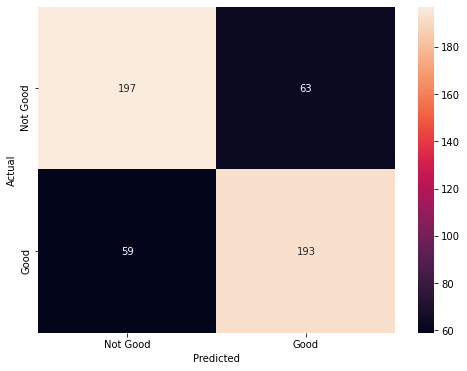

In [233]:
#plot confusion matrix

conf_mat = confusion_matrix(y_val, actual_pred_svc)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

ax.xaxis.set_ticklabels(['Not Good', 'Good'])
ax.yaxis.set_ticklabels(['Not Good', 'Good'])
plt.show()

In [172]:
%%time
#get the cross validation score on the X_train and y_train data
skf = StratifiedKFold(n_splits=5, random_state = 45, shuffle=True)

svc_cross_val = cross_val_score(svc_model, X_train, y_train, cv = skf, scoring='f1_macro')
print(svc_cross_val.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7449589438417745
Wall time: 56.6 s


In [173]:
# The Permutation based feature importance is used here
from sklearn.inspection import permutation_importance

#use the permutation importance function on the validation data
imps = permutation_importance(svc_model, X_val, y_val, n_repeats=30)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_val.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. ATTAINMENT_REP_LEVEL_BAND_PREV_FY (0.066304)
2. PRODUCT_ASSOCIATION (0.042860)
3. CAREER_LEVEL (0.042439)
4. TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN (0.041817)
5. MANAGER180_OVERALL_BAND_CURR_FY (0.038837)
6. TENURE_LATEST_HIRE_DATE_BAND_LIN (0.037539)
7. JOB_TENURE_BAND_LIN (0.033158)
8. MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL (0.030394)
9. TIME_SINCE_LAST_SALARY_INCR_BAND (0.029991)
10. AGE_BAND (0.029706)
11. NUM_MANAGER_CHANGE_PREV_FY (0.025162)
12. NUM_MANAGER_CHANGE_CURR_FY (0.023068)
13. NATIONALITY (0.018157)
14. MANAGER_GENDER_DESC (0.014261)
15. GENDER (0.009617)
16. SUBREGION (0.009013)
17. HIRE_EVENT_DESCRIPTION (0.008514)
18. NUM_JOB_CHANGE_CURR_FY (0.007088)
19. NUM_SALARY_CHANGE_PREV_FY (0.005172)
20. NUM_LOCATION_CHANGE_PREV_FY (0.004025)
21. NUM_ORG_CHANGE_CURR_FY (0.003982)
22. NUM_ORG_CHANGE_PREV_FY (0.002919)
23. NUM_JOB_CHANGE_PREV_FY (0.002273)
24. COUNTRY (0.002213)
25. NUM_CAREER_LEVEL_CHANGE_PREV_FY (0.002091)
26. RCODE_06 (0.001910)
27. NUM_LOC

In [174]:
#place the features into a dataframe and rename the columns

importances2 = list(zip(importances, X.columns))

svc_perm_impt = pd.DataFrame(importances2)

svc_perm_impt.rename(columns = {0:'Impt Values', 1:'Features'}, inplace = True)

In [175]:
#get the top 10 features

svc_perm_top10 = svc_perm_impt.sort_values(by=['Impt Values'], ascending=False).head(10)


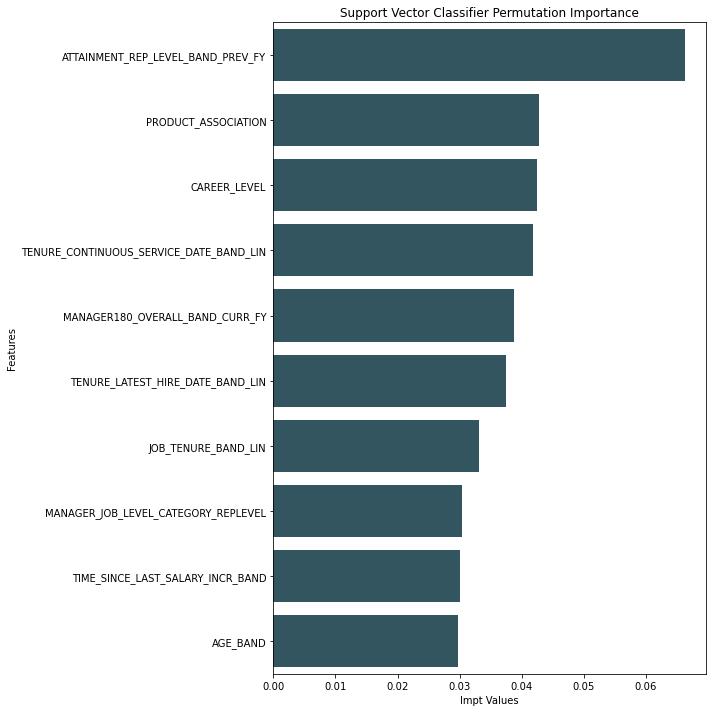

In [176]:
#plot the top 10 features in descending order

plt.figure(figsize=(10, 10))
features = sns.barplot(x="Impt Values", y="Features", data=svc_perm_top10.sort_values(by="Impt Values", ascending=False), color="#2C5967")
plt.title('Support Vector Classifier Permutation Importance')
plt.tight_layout()
plt.show()


figure = features.get_figure()
#save the chart for use later
figure.savefig('SVC_features.png', dpi=400)

<font size="4">**4.5 Shallow Neural Network with Oversampling**</font>

<font size="3">**Note: Keras Classifier is used so that integration with sklearn functions such as pipeline and randomised search would be possible**</font>


In [177]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

#import keras_tuner as kt

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

In [178]:
#use sklearn pipeline

from sklearn.pipeline import Pipeline

def create_network(unit,learn_rate=0.001):
    nn_model_best = keras.Sequential()
    # For the input layer, the units would be subjected to search
    nn_model_best.add(keras.layers.Dense(units=unit, activation='relu'))
    
    # Only one hidden layer is used, which means it is a shallow network
    nn_model_best.add(keras.layers.Dense(units=1, activation='sigmoid'))

    # Learning rate would be subjected to search
    opt = keras.optimizers.Adam(learning_rate= learn_rate)
    
    #binary_crossentropy is used for loss function as outcome is binary
    lossfunc = keras.losses.binary_crossentropy
    
    nn_model_best.compile(loss=lossfunc,optimizer=opt,metrics=['accuracy'])
    
    return nn_model_best


#define classifier
clf = KerasClassifier(build_fn=create_network,verbose=1)

#define the pipeline - chain the preprocessor step and the classifier
pipe = Pipeline([('preprocessor',preprocessor), ('clf',clf)])

In [179]:
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('scaler', MinMaxScaler())]),
                                   ['NUM_SALARY_CHANGE_PREV_FY',
                                    'NUM_SALARY_CHANGE_CURR_FY',
                                    'NUM_ORG_CHANGE_PREV_FY',
                                    'NUM_ORG_CHANGE_CURR_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_PREV_FY',
                                    'NUM_CAREER_LEVEL_CHANGE_CURR_FY',
                                    'NUM_MANAGER_CHANGE_PREV_FY',
                                    'NUM_MANAGER_CHANGE_CURR_FY',
                                    'NUM_JOB_CHANGE_PREV_FY',
                                    'NUM_JOB_...
                                    'TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN',
                                    'TENURE_LATEST_HIRE_DATE_BAND_LIN',
                                    'JOB_TENURE_BAND_LIN',
          

In [181]:
#randomised search with 5 fold cross validation
skf = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

#input the parameters for search space
param_grid = {
    'clf__unit': [5, 10, 15, 20, 25, 30],
    'clf__learn_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'clf__epochs': [5, 10, 15, 20, 25, 30],
    'clf__batch_size': [5, 10, 50, 100]
}


#create the neural network classifier object
rscv_nn = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, cv=skf, random_state=22, verbose=1)



In [658]:
%%time

#fit the nn_model with X_train and y_train data
nn_model = rscv_nn.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/15
123/123 [==============================] - 1s 775us/step - loss: 0.9028 - accuracy: 0.5391
Epoch 2/15
123/123 [==============================] - 0s 801us/step - loss: 0.7072 - accuracy: 0.4919
Epoch 3/15
123/123 [==============================] - 0s 770us/step - loss: 0.6964 - accuracy: 0.5130
Epoch 4/15
123/123 [==============================] - 0s 907us/step - loss: 0.7141 - accuracy: 0.5318
Epoch 5/15
123/123 [==============================] - 0s 875us/step - loss: 0.7047 - accuracy: 0.5122
Epoch 6/15
123/123 [==============================] - 0s 1ms/step - loss: 0.7071 - accuracy: 0.4910
Epoch 7/15
123/123 [==============================] - 0s 1ms/step - loss: 0.7015 - accuracy: 0.4984
Epoch 8/15
123/123 [==============================] - 0s 1ms/step - loss: 0.6997 - accuracy: 0.4927
Epoch 9/15
123/123 [==============================] - 0s 817us/step - loss: 0.6956 - accuracy: 0.5171
Epoch 10/15
123/123 [======

246/246 [==============================] - 0s 1ms/step - loss: 0.7212 - accuracy: 0.4845
Epoch 3/30
246/246 [==============================] - 0s 1ms/step - loss: 0.7128 - accuracy: 0.4756
Epoch 4/30
246/246 [==============================] - 0s 1ms/step - loss: 0.7063 - accuracy: 0.4943
Epoch 5/30
246/246 [==============================] - 0s 1ms/step - loss: 0.7062 - accuracy: 0.4731
Epoch 6/30
246/246 [==============================] - 0s 1ms/step - loss: 0.7047 - accuracy: 0.4959
Epoch 7/30
246/246 [==============================] - 0s 1ms/step - loss: 0.7136 - accuracy: 0.5049
Epoch 8/30
246/246 [==============================] - 0s 1ms/step - loss: 0.7011 - accuracy: 0.5073
Epoch 9/30
246/246 [==============================] - 0s 1ms/step - loss: 0.7033 - accuracy: 0.4951
Epoch 10/30
246/246 [==============================] - 0s 1ms/step - loss: 0.7067 - accuracy: 0.4772
Epoch 11/30
246/246 [==============================] - 0s 1ms/step - loss: 0.7044 - accuracy: 0.5041
Epoch 12/

123/123 [==============================] - 0s 972us/step - loss: 0.5173 - accuracy: 0.7386
Epoch 9/20
123/123 [==============================] - 0s 951us/step - loss: 0.5074 - accuracy: 0.7239
Epoch 10/20
123/123 [==============================] - 0s 957us/step - loss: 0.5181 - accuracy: 0.7337
Epoch 11/20
123/123 [==============================] - 0s 948us/step - loss: 0.5035 - accuracy: 0.7484
Epoch 12/20
123/123 [==============================] - 0s 976us/step - loss: 0.4950 - accuracy: 0.7581
Epoch 13/20
123/123 [==============================] - 0s 877us/step - loss: 0.4797 - accuracy: 0.7622
Epoch 14/20
123/123 [==============================] - 0s 977us/step - loss: 0.4738 - accuracy: 0.7451
Epoch 15/20
123/123 [==============================] - 0s 947us/step - loss: 0.4801 - accuracy: 0.7671
Epoch 16/20
123/123 [==============================] - 0s 866us/step - loss: 0.5125 - accuracy: 0.7402
Epoch 17/20
123/123 [==============================] - 0s 965us/step - loss: 0.5024 - 

123/123 [==============================] - 0s 1ms/step - loss: 0.7066 - accuracy: 0.5248
Epoch 4/30
123/123 [==============================] - 0s 1ms/step - loss: 0.7087 - accuracy: 0.5256
Epoch 5/30
123/123 [==============================] - 0s 1ms/step - loss: 0.7282 - accuracy: 0.4931
Epoch 6/30
123/123 [==============================] - 0s 1ms/step - loss: 0.7156 - accuracy: 0.5167
Epoch 7/30
123/123 [==============================] - 0s 1ms/step - loss: 0.7017 - accuracy: 0.4719
Epoch 8/30
123/123 [==============================] - 0s 1ms/step - loss: 0.7032 - accuracy: 0.4744
Epoch 9/30
123/123 [==============================] - 0s 1ms/step - loss: 0.6998 - accuracy: 0.5264
Epoch 10/30
123/123 [==============================] - 0s 1ms/step - loss: 0.7088 - accuracy: 0.4996
Epoch 11/30
123/123 [==============================] - 0s 1ms/step - loss: 0.6995 - accuracy: 0.5142
Epoch 12/30
123/123 [==============================] - 0s 1ms/step - loss: 0.7065 - accuracy: 0.4825
Epoch 13

246/246 [==============================] - 0s 1ms/step - loss: 0.5960 - accuracy: 0.6778
Epoch 10/15
246/246 [==============================] - 0s 1ms/step - loss: 0.5856 - accuracy: 0.6542
Epoch 11/15
246/246 [==============================] - 0s 1ms/step - loss: 0.5715 - accuracy: 0.6542
Epoch 12/15
246/246 [==============================] - 0s 1ms/step - loss: 0.5702 - accuracy: 0.6688
Epoch 13/15
246/246 [==============================] - 0s 1ms/step - loss: 0.5782 - accuracy: 0.6493
Epoch 14/15
246/246 [==============================] - 0s 1ms/step - loss: 0.6516 - accuracy: 0.5956
Epoch 15/15
62/62 [==============================] - 0s 762us/step - loss: 0.7532 - accuracy: 0.5700
Epoch 1/15
246/246 [==============================] - 1s 1ms/step - loss: 0.6080 - accuracy: 0.6564
Epoch 2/15
246/246 [==============================] - 0s 1ms/step - loss: 0.5423 - accuracy: 0.7419
Epoch 3/15
246/246 [==============================] - 0s 1ms/step - loss: 0.5146 - accuracy: 0.7410
Epoch

13/13 [==============================] - 0s 2ms/step - loss: 0.4773 - accuracy: 0.7836
Epoch 16/30
13/13 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.7852
Epoch 17/30
13/13 [==============================] - 0s 2ms/step - loss: 0.4920 - accuracy: 0.7705
Epoch 18/30
13/13 [==============================] - 0s 2ms/step - loss: 0.4738 - accuracy: 0.7852
Epoch 19/30
13/13 [==============================] - 0s 2ms/step - loss: 0.4597 - accuracy: 0.7836
Epoch 20/30
13/13 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.7868
Epoch 21/30
13/13 [==============================] - 0s 2ms/step - loss: 0.4643 - accuracy: 0.7917
Epoch 22/30
13/13 [==============================] - 0s 2ms/step - loss: 0.4578 - accuracy: 0.7876
Epoch 23/30
13/13 [==============================] - 0s 2ms/step - loss: 0.4637 - accuracy: 0.7893
Epoch 24/30
13/13 [==============================] - 0s 2ms/step - loss: 0.4578 - accuracy: 0.7909
Epoch 25/30
13/13 [===

246/246 [==============================] - 0s 1ms/step - loss: 0.5142 - accuracy: 0.7445
Epoch 25/30
246/246 [==============================] - 0s 1ms/step - loss: 0.5121 - accuracy: 0.7478
Epoch 26/30
246/246 [==============================] - 0s 1ms/step - loss: 0.4943 - accuracy: 0.7648
Epoch 27/30
246/246 [==============================] - 0s 1ms/step - loss: 0.4938 - accuracy: 0.7307
Epoch 28/30
246/246 [==============================] - 0s 1ms/step - loss: 0.5080 - accuracy: 0.7486
Epoch 29/30
246/246 [==============================] - 0s 1ms/step - loss: 0.4786 - accuracy: 0.7437
Epoch 30/30
62/62 [==============================] - 0s 799us/step - loss: 1.4111 - accuracy: 0.6743
Epoch 1/30
246/246 [==============================] - 1s 847us/step - loss: 0.6959 - accuracy: 0.6208
Epoch 2/30
246/246 [==============================] - 0s 888us/step - loss: 0.6765 - accuracy: 0.5728
Epoch 3/30
246/246 [==============================] - 0s 927us/step - loss: 0.6499 - accuracy: 0.6298

31/31 [==============================] - 0s 997us/step - loss: 0.9055 - accuracy: 0.4951
Epoch 1/30
123/123 [==============================] - 1s 922us/step - loss: 0.7238 - accuracy: 0.6282
Epoch 2/30
123/123 [==============================] - 0s 1ms/step - loss: 0.6351 - accuracy: 0.6550
Epoch 3/30
123/123 [==============================] - 0s 997us/step - loss: 0.6266 - accuracy: 0.6778
Epoch 4/30
123/123 [==============================] - 0s 965us/step - loss: 0.6532 - accuracy: 0.6282
Epoch 5/30
123/123 [==============================] - 0s 1ms/step - loss: 0.6648 - accuracy: 0.6029
Epoch 6/30
123/123 [==============================] - 0s 1ms/step - loss: 0.6491 - accuracy: 0.6143
Epoch 7/30
123/123 [==============================] - 0s 1ms/step - loss: 0.6785 - accuracy: 0.5956
Epoch 8/30
123/123 [==============================] - 0s 1ms/step - loss: 0.6970 - accuracy: 0.5102
Epoch 9/30
123/123 [==============================] - 0s 1ms/step - loss: 0.7008 - accuracy: 0.4809
Epoch

13/13 [==============================] - 0s 2ms/step - loss: 0.1959 - accuracy: 0.9259
Epoch 21/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1611 - accuracy: 0.9463
Epoch 22/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1502 - accuracy: 0.9487
Epoch 23/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1390 - accuracy: 0.9625
Epoch 24/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1364 - accuracy: 0.9577
Epoch 25/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1248 - accuracy: 0.9666
Epoch 26/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1175 - accuracy: 0.9634
Epoch 27/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1135 - accuracy: 0.9674
Epoch 28/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1103 - accuracy: 0.9691
Epoch 29/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1070 - accuracy: 0.9674
Epoch 30/30
4/4 [=====

In [659]:
#print best parameters and accuracy
print ('Best parameters found by randomised search are:', nn_model.best_params_)

print ('Best accuracy from randomised search is:', nn_model.best_score_)

Best parameters found by randomised search are: {'clf__unit': 30, 'clf__learn_rate': 0.01, 'clf__epochs': 30, 'clf__batch_size': 100}
Best accuracy from randomised search is: 0.7571767091751098


<font size="3">**Note: Refer to following link on how to save and load a keras model that is wrapped in sklearn**</font>

https://stackoverflow.com/questions/37984304/how-to-save-a-scikit-learn-pipline-with-keras-regressor-inside-to-disk

**Step 1: Saving the model and pipeline**

In [660]:
#ensure the model is retrieved via the named steps in randomised search
rscv_nn.best_estimator_.named_steps['clf'].model

In [661]:
# Save the Keras model first:
rscv_nn.best_estimator_.named_steps['clf'].model.save('fy21_rscv_nn_model_binarygoodnotgood.h5')

In [662]:
# This hack emptying the model allows us to save just the sklearn pipeline object:
rscv_nn.best_estimator_.named_steps['clf'].model = None

In [663]:
# Finally, save the pipeline using joblib
joblib.dump(rscv_nn.best_estimator_, 'fy21_rscv_nn_model_pipeline_binarygoodnotgood.pkl')


['fy21_nn_model_pipeline_binarygoodnotgood_v3.pkl']

**Step 2: Loading the pipeline, and then the model**

In [182]:
from keras.models import load_model

# Load the pipeline first:
rscv_nn.best_estimator_ = joblib.load('fy21_rscv_nn_model_pipeline_binarygoodnotgood.pkl')

# Then, load the Keras model:
rscv_nn.best_estimator_.named_steps['clf'].model = load_model('fy21_rscv_nn_model_binarygoodnotgood.h5')

In [184]:
#predict the test data
y_pred_nn = rscv_nn.best_estimator_.predict(X_test)

6/6 [==============================] - 5s 985us/step


In [185]:
#inspect classification metrics
print(metrics.classification_report(y_test,y_pred_nn))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       260
           1       0.72      0.73      0.73       252

    accuracy                           0.73       512
   macro avg       0.73      0.73      0.73       512
weighted avg       0.73      0.73      0.73       512



In [186]:
%%time
# actual prediction with validation data

actual_pred_nn = rscv_nn.best_estimator_.predict(X_val)

6/6 [==============================] - 0s 995us/step
Wall time: 21 ms


In [187]:
#inspect classification metrics
print(metrics.classification_report(y_val,actual_pred_nn))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       260
           1       0.78      0.74      0.76       252

    accuracy                           0.77       512
   macro avg       0.77      0.77      0.77       512
weighted avg       0.77      0.77      0.77       512



In [188]:
#save the predicted model
pkl_filename = 'fy21_nnpredictionmodel.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(actual_pred_nn, file)

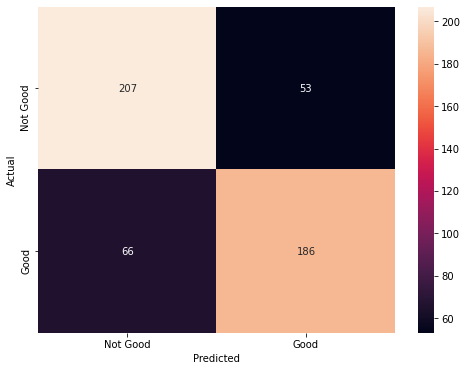

In [189]:
#plot confusion matrix

conf_mat = confusion_matrix(y_val, actual_pred_nn)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

ax.xaxis.set_ticklabels(['Not Good', 'Good'])
ax.yaxis.set_ticklabels(['Not Good', 'Good'])
plt.show()

In [667]:
# The Permutation based feature importance is used here

from sklearn.inspection import permutation_importance
#use the permutation importance function on validation data
imps = permutation_importance(rscv_nn.best_estimator_, X_val, y_val, n_repeats=30)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_val.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

6/6 [==============================] - 0s 998us/step - loss: 0.8606 - accuracy: 0.7344


6/6 [==============================] - 0s 2ms/step - loss: 0.8838 - accuracy: 0.7598


6/6 [==============================] - 0s 2ms/step - loss: 0.8239 - accuracy: 0.7676


6/6 [==============================] - 0s 2ms/step - loss: 0.8275 - accuracy: 0.7695


6/6 [==============================] - 0s 2ms/step - loss: 0.8431 - accuracy: 0.7578
Feature ranking:
1. MANAGER180_OVERALL_BAND_CURR_FY (0.058594)
2. ATTAINMENT_REP_LEVEL_BAND_PREV_FY (0.048828)
3. PRODUCT_ASSOCIATION (0.046354)
4. NATIONALITY (0.039779)
5. TIME_SINCE_LAST_SALARY_INCR_BAND (0.034310)
6. CAREER_LEVEL (0.025977)
7. TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN (0.025586)
8. AGE_BAND (0.023698)
9. MANAGER_GENDER_DESC (0.021159)
10. COUNTRY (0.021029)
11. RCODE_06 (0.018490)
12. SUBREGION (0.017188)
13. GENDER (0.015885)
14. TENURE_LATEST_HIRE_DATE_BAND_LIN (0.014909)
15. MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL (0.014258)
16. JOB_TENURE_BAND_LIN (0.013542)
17. HIRE_EVENT_DESCRIPTION (0.009831)
18. RCODE_07 (0.008984)
19. NUM_CAREER_LEVEL_CHANGE_CURR_FY (0.008789)
20. PRODUCT_LINE (0.007812)
21. NUM_SALARY_CHANGE_PREV_FY (0.003385)
22. NUM_MANAGER_CHANGE_CURR_FY (0.002539)
23. NUM_ORG_CHANGE_CURR_FY (0.000326)
24. NUM_LOCATION_CHANGE_CURR_FY (0.000195)
25. NUM_SALARY_CHANGE_CURR_FY 

In [668]:
#place the features into a dataframe and rename the columns

importances2 = list(zip(importances, X.columns))

nn_perm_impt = pd.DataFrame(importances2)

nn_perm_impt.rename(columns = {0:'Impt Values', 1:'Features'}, inplace = True)

In [669]:
#get the top 10 features

nn_perm_top10 = nn_perm_impt.sort_values(by=['Impt Values'], ascending=False).head(10)

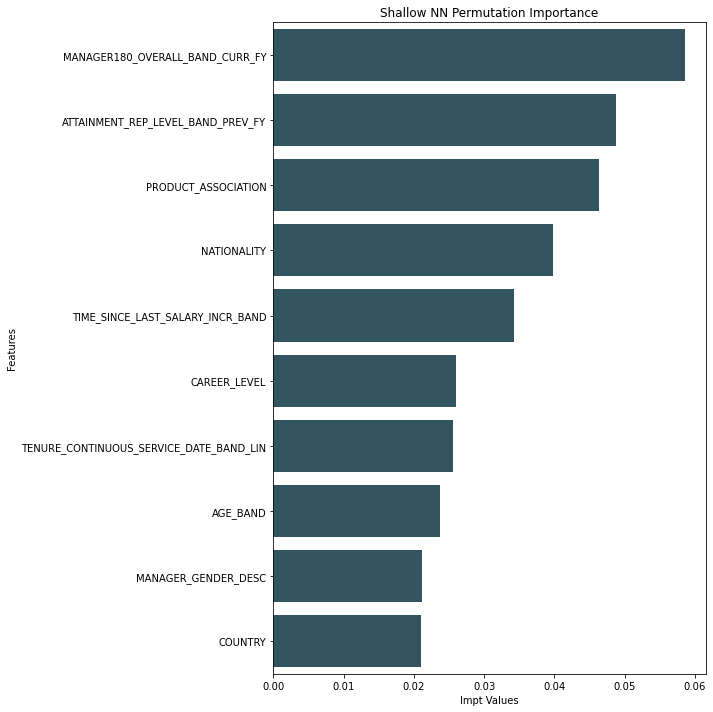

In [670]:
#plot the top 10 features in descending order

plt.figure(figsize=(10, 10))
features = sns.barplot(x="Impt Values", y="Features", data=nn_perm_top10.sort_values(by="Impt Values", ascending=False), color="#2C5967")
plt.title('Shallow NN Permutation Importance')
plt.tight_layout()
plt.show()


figure = features.get_figure()
#save the chart for use later
figure.savefig('Shallow_nn_features.png', dpi=400)

## Application 1: Predicting new classes using max voting

<font size="3">**Note: Max voting allows you to select the most commonly predicted class from the models trained. This helps to increase confidence in the class predicted**</font>

In [190]:
#load all the models
from keras.models import load_model

with open ('fy21_lr_rscv_binarygoodnotgood_model.pkl','rb') as file1:
    lr_model2 = pickle.load(file1)
    
with open ('fy21_rf_rscv_binarygoodnotgood_model.pkl','rb') as file2:
    rf_model = pickle.load(file2)
    
with open ('fy21_lgbm_rscv_binarygoodnotgood_model.pkl','rb') as file3:
    lgbm_model = pickle.load(file3)

with open ('fy21_svc_rscv_binarygoodnotgood_model.pkl','rb') as file4:
    svc_model = pickle.load(file4)
    


<font size="3">**Note: Before loading the pipeline and the keras model, be sure to import the keras libraries, to run the 'create_network' function, to run the randomised search cv and create the nn classifier object. Not doing so would lead to error as the create_network function is not saved in the pipeline nor model**</font>


In [191]:
#before loading the pipeline and the keras model
#make sure to import the keras libraries, to run the 'create_network' function, and to run the randomised search cv object

#load all the models
from keras.models import load_model

# Load the pipeline first:
rscv_nn.best_estimator_ = joblib.load('fy21_nn_model_pipeline_binarygoodnotgood_v3.pkl')

# Then, load the Keras model:
rscv_nn.best_estimator_.named_steps['clf'].model = load_model('fy21_nn_model_binarygoodnotgood_v3.h5')

In [192]:
#rscv_nn.estimator = joblib.load('fy21_nn_model_pipeline_binarygoodnotgood_test1.pkl')

# rscv_nn = joblib.load('fy21_nn_model_pipeline_binarygoodnotgood_test2.pkl')


<font size="3">**Note: Load in the new data that has been subjected to preprocessing and feature engineering**</font>

In [8]:
#change directory and load the dataset
os.chdir('C:/Users/weijtan/Desktop/NUS/Capstone/data')

df_new = pd.read_csv('./data/FY22 Performance of Sales Reps - Sample Dataset v2.csv', encoding='utf-8')

In [10]:
print(df_new.shape)
print(X_val.shape)

In [195]:
df_new.columns

Index(['SUBREGION', 'COUNTRY', 'CAREER_LEVEL', 'TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN', 'TENURE_LATEST_HIRE_DATE_BAND_LIN', 'JOB_TENURE_BAND_LIN', 'TIME_SINCE_LAST_SALARY_INCR_BAND', 'GENDER', 'AGE_BAND', 'PRODUCT_LINE', 'PRODUCT_ASSOCIATION', 'RCODE_06', 'RCODE_07', 'NATIONALITY', 'MANAGER_GENDER_DESC', 'HIRE_EVENT_DESCRIPTION', 'NUM_SALARY_CHANGE_PREV_FY', 'NUM_SALARY_CHANGE_CURR_FY', 'NUM_ORG_CHANGE_PREV_FY', 'NUM_ORG_CHANGE_CURR_FY', 'NUM_CAREER_LEVEL_CHANGE_PREV_FY', 'NUM_CAREER_LEVEL_CHANGE_CURR_FY', 'NUM_MANAGER_CHANGE_PREV_FY', 'NUM_MANAGER_CHANGE_CURR_FY', 'NUM_JOB_CHANGE_PREV_FY', 'NUM_JOB_CHANGE_CURR_FY', 'NUM_LOCATION_CHANGE_PREV_FY', 'NUM_LOCATION_CHANGE_CURR_FY', 'MANAGER180_OVERALL_BAND_CURR_FY', 'ATTAINMENT_REP_LEVEL_BAND_PREV_FY', 'MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL'], dtype='object')

In [196]:
X_val.columns

Index(['SUBREGION', 'COUNTRY', 'CAREER_LEVEL', 'TENURE_CONTINUOUS_SERVICE_DATE_BAND_LIN', 'TENURE_LATEST_HIRE_DATE_BAND_LIN', 'JOB_TENURE_BAND_LIN', 'TIME_SINCE_LAST_SALARY_INCR_BAND', 'GENDER', 'AGE_BAND', 'PRODUCT_LINE', 'PRODUCT_ASSOCIATION', 'RCODE_06', 'RCODE_07', 'NATIONALITY', 'MANAGER_GENDER_DESC', 'HIRE_EVENT_DESCRIPTION', 'NUM_SALARY_CHANGE_PREV_FY', 'NUM_SALARY_CHANGE_CURR_FY', 'NUM_ORG_CHANGE_PREV_FY', 'NUM_ORG_CHANGE_CURR_FY', 'NUM_CAREER_LEVEL_CHANGE_PREV_FY', 'NUM_CAREER_LEVEL_CHANGE_CURR_FY', 'NUM_MANAGER_CHANGE_PREV_FY', 'NUM_MANAGER_CHANGE_CURR_FY', 'NUM_JOB_CHANGE_PREV_FY', 'NUM_JOB_CHANGE_CURR_FY', 'NUM_LOCATION_CHANGE_PREV_FY', 'NUM_LOCATION_CHANGE_CURR_FY', 'MANAGER180_OVERALL_BAND_CURR_FY', 'ATTAINMENT_REP_LEVEL_BAND_PREV_FY', 'MANAGER_JOB_LEVEL_CATEGORY_REPLEVEL'], dtype='object')

In [197]:
#lr_model - prediction on new data
lr2_pred_new = lr_model2.predict(df_new)

In [198]:
#rf_model - prediction on new data
rf_pred_new = rf_model.predict(df_new)

In [199]:
#lgbm_model - prediction on new data
lgbm_pred_new = lgbm_model.predict(df_new)

In [200]:
#svc_model - prediction on new data
svc_pred_new = svc_model.predict(df_new)


In [201]:
#nn_model - prediction on new data
nn_pred_new = rscv_nn.best_estimator_.predict(df_new)


14/14 [==============================] - 0s 923us/step


In [202]:
#insert the results of the predictions derived from the 5 models into a dataframe
df_predict_classes = pd.DataFrame(data=[lr2_pred_new, rf_pred_new, lgbm_pred_new, svc_pred_new, nn_pred_new]).T

In [203]:
#check the dataframe
df_predict_classes

,0,1,2,3,4
0,1,0,1,1,[1]
1,0,0,0,0,[0]
2,1,0,0,1,[0]
3,1,0,0,0,[0]
4,0,0,0,0,[0]
...,...,...,...,...,...
1357,1,1,0,0,[0]
1358,0,1,0,0,[0]
1359,1,0,0,1,[0]
1360,1,1,1,1,[1]


In [204]:
#insert the column names
df_predict_classes.columns = ['LOGISTIC_REGRESSION','RANDOM_FOREST','LIGHTGBM','SUPPORT_VECTOR','SHALLOW_NN']

In [205]:
#remove the brackets of the NN column
df_predict_classes= df_predict_classes.explode('SHALLOW_NN')

In [206]:
#check the dataframe
df_predict_classes

,LOGISTIC_REGRESSION,RANDOM_FOREST,LIGHTGBM,SUPPORT_VECTOR,SHALLOW_NN
0,1,0,1,1,1
1,0,0,0,0,0
2,1,0,0,1,0
3,1,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
1357,1,1,0,0,0
1358,0,1,0,0,0
1359,1,0,0,1,0
1360,1,1,1,1,1


In [208]:
#use the mode to get the most commonly predicted class. 
#since there are 5 models, there will not be any tie

df_predict_classes['MAX_VOTE'] = df_predict_classes.mode(axis=1)

In [210]:
#change the values to string to make it easier for interpretation
d = {'0': 'Not Good', '1' :'Good'}
cols = ['LOGISTIC_REGRESSION','RANDOM_FOREST','LIGHTGBM','SUPPORT_VECTOR','SHALLOW_NN','MAX_VOTE']
df_predict_classes[cols] = df_predict_classes[cols].replace(d, regex=True)

In [211]:
df_predict_classes

,LOGISTIC_REGRESSION,RANDOM_FOREST,LIGHTGBM,SUPPORT_VECTOR,SHALLOW_NN,MAX_VOTE
0,Good,Not Good,Good,Good,Good,Good
1,Not Good,Not Good,Not Good,Not Good,Not Good,Not Good
2,Good,Not Good,Not Good,Good,Not Good,Not Good
3,Good,Not Good,Not Good,Not Good,Not Good,Not Good
4,Not Good,Not Good,Not Good,Not Good,Not Good,Not Good
...,...,...,...,...,...,...
1357,Good,Good,Not Good,Not Good,Not Good,Not Good
1358,Not Good,Good,Not Good,Not Good,Not Good,Not Good
1359,Good,Not Good,Not Good,Good,Not Good,Not Good
1360,Good,Good,Good,Good,Good,Good


In [212]:
#merge predictions with original dataframe of the new data
df_out = pd.merge(df_new,df_predict_classes,how = 'left',left_index = True, right_index = True)


In [213]:
#save the dataframe
#df_out.to_csv('./data/Predictions for FY22 Sales Rep Performance.csv', encoding ='utf-8')

## Supplementary: Model Evaluation using ROC AUC (optional to run)

<font size="3">**Note: Generally, the use of ROC curves and precision-recall curves are as follows:**</font>

<font size="3">**ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.
The reason for this recommendation is that ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution**</font>

<font size="3">**Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.**</font>

from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/


In [12]:
## ROC AUC
y_test.value_counts()

<font size="2">**Note: in y_test, 'Not Good' was coded as '0' and 'Good' was coded as '1'**</font>

<font size="2">**check y_test index and df2 index for confirmation**</font>

In [13]:
#check value counts
y_test.value_counts()

In [216]:
#test the auc for random forest
#in this case, the [:,1] is used to predict classes that are 'Good'
auc1 = metrics.roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

In [217]:
auc1

0.8412393162393164

In [14]:
#check value counts
#y_val.value_counts()

In [219]:
#y values have to binarized first
lb = LabelBinarizer()

dummy_y_val = lb.fit_transform(y_val)

<font size="3">**Note: [:,1] means predicting the probabilities for positive class - which are the good performers**</font>

In [234]:
#predict the probabilities of the validation data for positive class
#use metrics.roc_curve function to calculate the false positive rate and true positive rate
#use the values to get the auc score

y_pred_proba_lr = lr_model2.predict_proba(X_val)[:,1]
fpr1, tpr1, _ = metrics.roc_curve(dummy_y_val, y_pred_proba_lr, pos_label=1)
auc1 = metrics.roc_auc_score(dummy_y_val, y_pred_proba_lr)


y_pred_proba_rf = rf_model.predict_proba(X_val)[:,1]
fpr2, tpr2, _ = metrics.roc_curve(dummy_y_val, y_pred_proba_rf, pos_label=1)
auc2 = metrics.roc_auc_score(dummy_y_val, y_pred_proba_rf)

y_pred_proba_lgbm = lgbm_model.predict_proba(X_val)[:,1]
fpr3, tpr3, _ = metrics.roc_curve(dummy_y_val, y_pred_proba_lgbm, pos_label=1)
auc3 = metrics.roc_auc_score(dummy_y_val, y_pred_proba_lgbm)


y_pred_proba_svc = svc_model.predict_proba(X_val)[:,1]
fpr4, tpr4, _ = metrics.roc_curve(dummy_y_val, y_pred_proba_svc, pos_label=1)
auc4 = metrics.roc_auc_score(dummy_y_val, y_pred_proba_svc)

# y_pred_proba_nn = nn_model_best.predict_proba(X_test)[::,1]
# fpr4, tpr4, _ = metrics.roc_curve(y_test2, y_pred_proba_nn)
# auc4 = metrics.roc_auc_score(y_test2, y_pred_proba_nn)


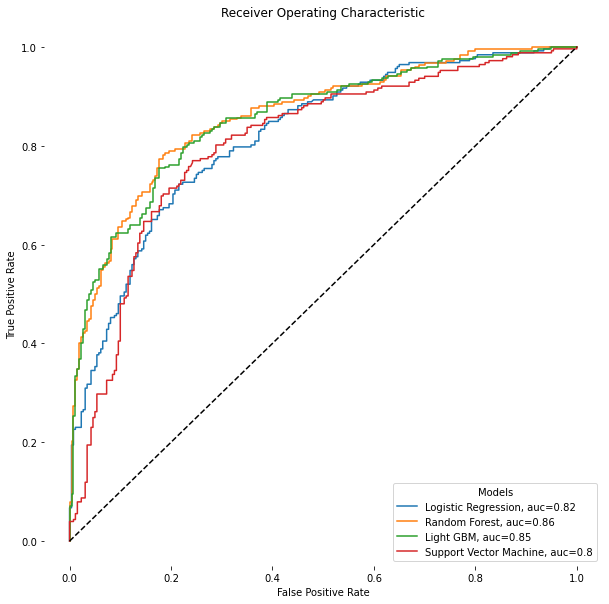

In [235]:
#plot the AUC curve for all 4 algorithms
plt.figure(figsize =(10,10))


plt.plot(fpr1, tpr1, label= "Logistic Regression, auc=" +str(round(auc1,2)))
plt.plot(fpr2, tpr2, label= "Random Forest, auc=" +str(round(auc2,2)))
plt.plot(fpr3, tpr3, label= "Light GBM, auc=" +str(round(auc3,2)))
plt.plot(fpr4, tpr4, label= "Support Vector Machine, auc=" +str(round(auc4,2)))

plt.plot([0,1], [0,1], 'k--')

plt.legend(loc=4, title = 'Models', facecolor='white')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic', size = 12)
plt.box(False)
